In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import numpy as np
# https://github.com/eriklindernoren/Keras-GAN

Using TensorFlow backend.


In [2]:
def trainClassif():
    (train_set, train_label_raw), (_, _) = mnist.load_data()
    train_label = to_categorical(train_label_raw)
    train_data = np.asarray(train_set).reshape(60000, 28, 28, 1)
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=43)

#     test_data = test_set.reshape(10000, 28, 28, 1)

    np.shape(train_data)

    model = Sequential()
    # model.add(Conv2D(5, kernel_size=3, activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # model.summary()

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4)
    return model

In [3]:
classif = trainClassif()

Train on 40200 samples, validate on 19800 samples
Epoch 1/5
40200/40200 [==============================] - 11s 283us/step - loss: 4.7200 - acc: 0.6677 - val_loss: 0.2467 - val_acc: 0.9388
Epoch 2/5
40200/40200 [==============================] - 8s 206us/step - loss: 0.1689 - acc: 0.9536 - val_loss: 0.1655 - val_acc: 0.9550
Epoch 3/5
40200/40200 [==============================] - 8s 203us/step - loss: 0.1077 - acc: 0.9683 - val_loss: 0.1132 - val_acc: 0.9664
Epoch 4/5
40200/40200 [==============================] - 8s 206us/step - loss: 0.0884 - acc: 0.9729 - val_loss: 0.0863 - val_acc: 0.9775
Epoch 5/5
40200/40200 [==============================] - 8s 204us/step - loss: 0.0742 - acc: 0.9772 - val_loss: 0.0932 - val_acc: 0.9736


In [33]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                # REMEMBER TO CHANGE TO PARAM DIRECTORY
#                 os.makedirs('saved_model_weights', exist_ok=True)
#                 generator.save_weights('saved_model_weights/generator_weights_%d.h5'%epoch)
#                 discriminator.save_weights('saved_model_weights/discriminator_weights_%d.h5'%epoch)
#                 combined.save_weights('saved_model_weights/combined_weights-%d.h5'%epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()
        
    def generate_images(self, num):
        r, c = 2, 5
        arr_imgs = []
        arr_labels = []
        for i in range(0, num):
            noise = np.random.normal(0, 1, (2 * 5, 100))
            sampled_labels = np.arange(0, 10).reshape(-1, 1)
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
            arr_imgs.append(gen_imgs)
            arr_labels.append(sampled_labels)
            
        out_imgs = np.asarray(arr_imgs).reshape(num*10, 28, 28, 1)
        out_labels = np.asarray(arr_labels).reshape(num*10, 1)
        
        return out_imgs, out_labels

In [34]:
cgan = CGAN()
cgan.train(epochs=10001, batch_size=128, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 513       
Total params: 665,089
Trainable params: 665,089
Non-trainable params: 0
_________________________________________________________________
____

109 [D loss: 0.357165, acc.: 84.38%] [G loss: 2.727354]
110 [D loss: 0.322757, acc.: 89.45%] [G loss: 2.686010]
111 [D loss: 0.324326, acc.: 84.77%] [G loss: 2.873306]
112 [D loss: 0.366958, acc.: 86.72%] [G loss: 2.809404]
113 [D loss: 0.321728, acc.: 85.94%] [G loss: 2.676615]
114 [D loss: 0.279512, acc.: 89.45%] [G loss: 2.740302]
115 [D loss: 0.295174, acc.: 86.72%] [G loss: 2.574110]
116 [D loss: 0.377939, acc.: 82.42%] [G loss: 2.590539]
117 [D loss: 0.340204, acc.: 82.81%] [G loss: 2.844812]
118 [D loss: 0.405060, acc.: 82.81%] [G loss: 2.634078]
119 [D loss: 0.331322, acc.: 83.98%] [G loss: 2.737196]
120 [D loss: 0.409344, acc.: 78.91%] [G loss: 2.766573]
121 [D loss: 0.434845, acc.: 79.69%] [G loss: 2.690138]
122 [D loss: 0.329766, acc.: 88.28%] [G loss: 2.702333]
123 [D loss: 0.370536, acc.: 83.20%] [G loss: 2.595882]
124 [D loss: 0.336154, acc.: 87.11%] [G loss: 2.601933]
125 [D loss: 0.368763, acc.: 83.20%] [G loss: 2.660413]
126 [D loss: 0.394079, acc.: 83.98%] [G loss: 2.

256 [D loss: 0.634528, acc.: 54.30%] [G loss: 1.361264]
257 [D loss: 0.656296, acc.: 49.61%] [G loss: 1.383190]
258 [D loss: 0.676308, acc.: 54.30%] [G loss: 1.455107]
259 [D loss: 0.642708, acc.: 53.52%] [G loss: 1.471406]
260 [D loss: 0.676830, acc.: 53.91%] [G loss: 1.351415]
261 [D loss: 0.686379, acc.: 48.83%] [G loss: 1.303331]
262 [D loss: 0.646126, acc.: 53.12%] [G loss: 1.385128]
263 [D loss: 0.671697, acc.: 51.95%] [G loss: 1.413832]
264 [D loss: 0.618810, acc.: 57.81%] [G loss: 1.373189]
265 [D loss: 0.663812, acc.: 54.30%] [G loss: 1.370803]
266 [D loss: 0.647770, acc.: 58.98%] [G loss: 1.359070]
267 [D loss: 0.683339, acc.: 50.39%] [G loss: 1.729068]
268 [D loss: 0.664196, acc.: 53.12%] [G loss: 1.391255]
269 [D loss: 0.626858, acc.: 61.72%] [G loss: 1.349677]
270 [D loss: 0.639439, acc.: 60.16%] [G loss: 1.291974]
271 [D loss: 0.614849, acc.: 67.19%] [G loss: 1.256863]
272 [D loss: 0.656773, acc.: 62.89%] [G loss: 1.292619]
273 [D loss: 0.644206, acc.: 57.81%] [G loss: 1.

403 [D loss: 0.684531, acc.: 51.17%] [G loss: 1.169573]
404 [D loss: 0.677382, acc.: 48.05%] [G loss: 0.948082]
405 [D loss: 0.718873, acc.: 41.80%] [G loss: 0.909481]
406 [D loss: 0.702117, acc.: 41.80%] [G loss: 0.951977]
407 [D loss: 0.692166, acc.: 50.78%] [G loss: 0.993234]
408 [D loss: 0.677388, acc.: 48.83%] [G loss: 1.018237]
409 [D loss: 0.685056, acc.: 51.17%] [G loss: 0.971866]
410 [D loss: 0.687725, acc.: 53.12%] [G loss: 1.003338]
411 [D loss: 0.658805, acc.: 53.12%] [G loss: 1.090343]
412 [D loss: 0.682053, acc.: 52.73%] [G loss: 1.037835]
413 [D loss: 0.667868, acc.: 53.52%] [G loss: 0.986868]
414 [D loss: 0.667519, acc.: 54.30%] [G loss: 1.053627]
415 [D loss: 0.675097, acc.: 54.69%] [G loss: 1.020544]
416 [D loss: 0.652579, acc.: 57.03%] [G loss: 1.045135]
417 [D loss: 0.666195, acc.: 55.08%] [G loss: 0.954597]
418 [D loss: 0.672938, acc.: 53.52%] [G loss: 1.095308]
419 [D loss: 0.654518, acc.: 55.08%] [G loss: 0.997177]
420 [D loss: 0.698757, acc.: 51.56%] [G loss: 0.

552 [D loss: 0.683827, acc.: 45.70%] [G loss: 0.935659]
553 [D loss: 0.683626, acc.: 53.12%] [G loss: 0.885970]
554 [D loss: 0.685410, acc.: 56.25%] [G loss: 0.903417]
555 [D loss: 0.674789, acc.: 53.12%] [G loss: 0.899949]
556 [D loss: 0.662251, acc.: 55.08%] [G loss: 0.887030]
557 [D loss: 0.674338, acc.: 55.47%] [G loss: 0.849728]
558 [D loss: 0.672449, acc.: 55.47%] [G loss: 0.886808]
559 [D loss: 0.686140, acc.: 48.83%] [G loss: 0.879357]
560 [D loss: 0.673172, acc.: 52.34%] [G loss: 0.876187]
561 [D loss: 0.672321, acc.: 63.28%] [G loss: 0.918351]
562 [D loss: 0.678187, acc.: 62.50%] [G loss: 0.889866]
563 [D loss: 0.687543, acc.: 51.95%] [G loss: 0.880758]
564 [D loss: 0.684997, acc.: 55.86%] [G loss: 0.894639]
565 [D loss: 0.692208, acc.: 49.22%] [G loss: 0.894791]
566 [D loss: 0.669255, acc.: 54.69%] [G loss: 0.909958]
567 [D loss: 0.703202, acc.: 50.78%] [G loss: 0.959229]
568 [D loss: 0.690215, acc.: 54.30%] [G loss: 0.870958]
569 [D loss: 0.687883, acc.: 53.12%] [G loss: 0.

705 [D loss: 0.701879, acc.: 45.70%] [G loss: 0.801847]
706 [D loss: 0.701767, acc.: 45.31%] [G loss: 0.821026]
707 [D loss: 0.712597, acc.: 40.62%] [G loss: 0.811992]
708 [D loss: 0.701830, acc.: 43.36%] [G loss: 0.797309]
709 [D loss: 0.710362, acc.: 47.27%] [G loss: 0.820375]
710 [D loss: 0.704394, acc.: 42.19%] [G loss: 0.820697]
711 [D loss: 0.712305, acc.: 41.80%] [G loss: 0.846149]
712 [D loss: 0.694954, acc.: 48.44%] [G loss: 0.808427]
713 [D loss: 0.710812, acc.: 47.66%] [G loss: 0.821299]
714 [D loss: 0.702585, acc.: 40.62%] [G loss: 0.816068]
715 [D loss: 0.697777, acc.: 43.75%] [G loss: 0.791235]
716 [D loss: 0.715876, acc.: 44.53%] [G loss: 0.777607]
717 [D loss: 0.694221, acc.: 49.22%] [G loss: 0.826740]
718 [D loss: 0.711818, acc.: 38.67%] [G loss: 0.792970]
719 [D loss: 0.707470, acc.: 47.27%] [G loss: 0.804514]
720 [D loss: 0.694725, acc.: 50.39%] [G loss: 0.838840]
721 [D loss: 0.704475, acc.: 48.44%] [G loss: 0.825474]
722 [D loss: 0.687247, acc.: 43.75%] [G loss: 0.

854 [D loss: 0.676353, acc.: 60.16%] [G loss: 0.809903]
855 [D loss: 0.686173, acc.: 47.66%] [G loss: 0.787290]
856 [D loss: 0.697071, acc.: 48.83%] [G loss: 0.795139]
857 [D loss: 0.678243, acc.: 53.12%] [G loss: 0.807061]
858 [D loss: 0.689497, acc.: 50.39%] [G loss: 0.793204]
859 [D loss: 0.682243, acc.: 55.47%] [G loss: 0.817729]
860 [D loss: 0.681352, acc.: 55.86%] [G loss: 0.814448]
861 [D loss: 0.684033, acc.: 51.17%] [G loss: 0.805757]
862 [D loss: 0.685246, acc.: 52.73%] [G loss: 0.788174]
863 [D loss: 0.692464, acc.: 48.44%] [G loss: 0.834737]
864 [D loss: 0.690485, acc.: 49.22%] [G loss: 0.833421]
865 [D loss: 0.683181, acc.: 50.78%] [G loss: 0.811248]
866 [D loss: 0.690474, acc.: 50.39%] [G loss: 0.805556]
867 [D loss: 0.692067, acc.: 56.25%] [G loss: 0.818260]
868 [D loss: 0.695706, acc.: 46.09%] [G loss: 0.806537]
869 [D loss: 0.676937, acc.: 53.91%] [G loss: 0.791480]
870 [D loss: 0.688804, acc.: 48.05%] [G loss: 0.783347]
871 [D loss: 0.682578, acc.: 51.95%] [G loss: 0.

1004 [D loss: 0.672655, acc.: 60.55%] [G loss: 0.784737]
1005 [D loss: 0.683479, acc.: 57.03%] [G loss: 0.801250]
1006 [D loss: 0.674398, acc.: 63.28%] [G loss: 0.800337]
1007 [D loss: 0.680499, acc.: 53.52%] [G loss: 0.795225]
1008 [D loss: 0.681778, acc.: 60.16%] [G loss: 0.810940]
1009 [D loss: 0.679517, acc.: 54.30%] [G loss: 0.821348]
1010 [D loss: 0.683164, acc.: 56.64%] [G loss: 0.794116]
1011 [D loss: 0.688396, acc.: 57.03%] [G loss: 0.790598]
1012 [D loss: 0.676599, acc.: 62.50%] [G loss: 0.801739]
1013 [D loss: 0.682880, acc.: 58.98%] [G loss: 0.784119]
1014 [D loss: 0.682777, acc.: 53.52%] [G loss: 0.782785]
1015 [D loss: 0.667170, acc.: 62.50%] [G loss: 0.794686]
1016 [D loss: 0.661840, acc.: 64.06%] [G loss: 0.793270]
1017 [D loss: 0.669649, acc.: 59.77%] [G loss: 0.791802]
1018 [D loss: 0.691067, acc.: 52.73%] [G loss: 0.796062]
1019 [D loss: 0.682791, acc.: 57.81%] [G loss: 0.801497]
1020 [D loss: 0.676797, acc.: 59.38%] [G loss: 0.795749]
1021 [D loss: 0.668823, acc.: 6

1153 [D loss: 0.694609, acc.: 50.78%] [G loss: 0.787779]
1154 [D loss: 0.698202, acc.: 45.70%] [G loss: 0.766115]
1155 [D loss: 0.688685, acc.: 53.91%] [G loss: 0.781558]
1156 [D loss: 0.695301, acc.: 53.12%] [G loss: 0.769570]
1157 [D loss: 0.701349, acc.: 49.61%] [G loss: 0.761883]
1158 [D loss: 0.691169, acc.: 51.56%] [G loss: 0.781464]
1159 [D loss: 0.694714, acc.: 48.05%] [G loss: 0.764908]
1160 [D loss: 0.688374, acc.: 51.17%] [G loss: 0.761821]
1161 [D loss: 0.698180, acc.: 50.39%] [G loss: 0.770253]
1162 [D loss: 0.704875, acc.: 44.14%] [G loss: 0.750655]
1163 [D loss: 0.685872, acc.: 52.73%] [G loss: 0.770339]
1164 [D loss: 0.693773, acc.: 49.61%] [G loss: 0.778431]
1165 [D loss: 0.687276, acc.: 51.56%] [G loss: 0.782067]
1166 [D loss: 0.693748, acc.: 51.17%] [G loss: 0.775170]
1167 [D loss: 0.686580, acc.: 53.52%] [G loss: 0.777168]
1168 [D loss: 0.691293, acc.: 52.34%] [G loss: 0.787633]
1169 [D loss: 0.688941, acc.: 51.17%] [G loss: 0.774686]
1170 [D loss: 0.689601, acc.: 5

1297 [D loss: 0.680633, acc.: 53.91%] [G loss: 0.776823]
1298 [D loss: 0.685693, acc.: 50.78%] [G loss: 0.785746]
1299 [D loss: 0.680406, acc.: 53.52%] [G loss: 0.772526]
1300 [D loss: 0.684428, acc.: 55.08%] [G loss: 0.768496]
1301 [D loss: 0.688561, acc.: 51.95%] [G loss: 0.777348]
1302 [D loss: 0.675584, acc.: 56.25%] [G loss: 0.771646]
1303 [D loss: 0.686695, acc.: 48.44%] [G loss: 0.770421]
1304 [D loss: 0.680931, acc.: 55.08%] [G loss: 0.773183]
1305 [D loss: 0.682208, acc.: 55.47%] [G loss: 0.772323]
1306 [D loss: 0.691543, acc.: 52.34%] [G loss: 0.778324]
1307 [D loss: 0.688657, acc.: 52.34%] [G loss: 0.764358]
1308 [D loss: 0.674209, acc.: 57.03%] [G loss: 0.783942]
1309 [D loss: 0.665320, acc.: 58.98%] [G loss: 0.787678]
1310 [D loss: 0.692529, acc.: 52.73%] [G loss: 0.767559]
1311 [D loss: 0.695108, acc.: 47.66%] [G loss: 0.765851]
1312 [D loss: 0.682143, acc.: 53.52%] [G loss: 0.774329]
1313 [D loss: 0.685866, acc.: 51.17%] [G loss: 0.773550]
1314 [D loss: 0.682963, acc.: 5

1448 [D loss: 0.679537, acc.: 54.30%] [G loss: 0.783436]
1449 [D loss: 0.692924, acc.: 50.39%] [G loss: 0.769634]
1450 [D loss: 0.672467, acc.: 58.59%] [G loss: 0.775382]
1451 [D loss: 0.676499, acc.: 58.59%] [G loss: 0.771268]
1452 [D loss: 0.681670, acc.: 52.73%] [G loss: 0.779799]
1453 [D loss: 0.683556, acc.: 54.30%] [G loss: 0.781378]
1454 [D loss: 0.682338, acc.: 58.20%] [G loss: 0.767740]
1455 [D loss: 0.682338, acc.: 55.47%] [G loss: 0.781190]
1456 [D loss: 0.691702, acc.: 52.34%] [G loss: 0.793178]
1457 [D loss: 0.680693, acc.: 55.47%] [G loss: 0.762269]
1458 [D loss: 0.675047, acc.: 58.59%] [G loss: 0.770334]
1459 [D loss: 0.689196, acc.: 51.17%] [G loss: 0.778478]
1460 [D loss: 0.679987, acc.: 56.25%] [G loss: 0.773905]
1461 [D loss: 0.676893, acc.: 58.98%] [G loss: 0.778644]
1462 [D loss: 0.683093, acc.: 55.86%] [G loss: 0.767740]
1463 [D loss: 0.674378, acc.: 58.20%] [G loss: 0.787420]
1464 [D loss: 0.694005, acc.: 51.56%] [G loss: 0.764283]
1465 [D loss: 0.692956, acc.: 5

1593 [D loss: 0.698616, acc.: 44.14%] [G loss: 0.766751]
1594 [D loss: 0.692380, acc.: 52.34%] [G loss: 0.760913]
1595 [D loss: 0.688092, acc.: 55.86%] [G loss: 0.750895]
1596 [D loss: 0.692420, acc.: 53.91%] [G loss: 0.765688]
1597 [D loss: 0.694103, acc.: 51.17%] [G loss: 0.755420]
1598 [D loss: 0.693429, acc.: 51.95%] [G loss: 0.767123]
1599 [D loss: 0.682015, acc.: 56.64%] [G loss: 0.760962]
1600 [D loss: 0.687129, acc.: 56.64%] [G loss: 0.758935]
1601 [D loss: 0.684193, acc.: 56.25%] [G loss: 0.765642]
1602 [D loss: 0.685298, acc.: 55.08%] [G loss: 0.752177]
1603 [D loss: 0.687134, acc.: 55.08%] [G loss: 0.760583]
1604 [D loss: 0.690751, acc.: 52.73%] [G loss: 0.760431]
1605 [D loss: 0.700323, acc.: 48.05%] [G loss: 0.760014]
1606 [D loss: 0.695851, acc.: 43.75%] [G loss: 0.766724]
1607 [D loss: 0.691599, acc.: 51.17%] [G loss: 0.745944]
1608 [D loss: 0.698967, acc.: 49.22%] [G loss: 0.755875]
1609 [D loss: 0.697294, acc.: 47.27%] [G loss: 0.765153]
1610 [D loss: 0.694882, acc.: 5

1742 [D loss: 0.695774, acc.: 49.22%] [G loss: 0.761131]
1743 [D loss: 0.693948, acc.: 49.61%] [G loss: 0.762293]
1744 [D loss: 0.680770, acc.: 52.34%] [G loss: 0.755587]
1745 [D loss: 0.696441, acc.: 50.00%] [G loss: 0.753140]
1746 [D loss: 0.687828, acc.: 50.78%] [G loss: 0.758575]
1747 [D loss: 0.683327, acc.: 55.47%] [G loss: 0.759999]
1748 [D loss: 0.690308, acc.: 50.78%] [G loss: 0.760313]
1749 [D loss: 0.689508, acc.: 51.95%] [G loss: 0.764711]
1750 [D loss: 0.689753, acc.: 51.95%] [G loss: 0.763629]
1751 [D loss: 0.691478, acc.: 50.78%] [G loss: 0.769879]
1752 [D loss: 0.689426, acc.: 51.95%] [G loss: 0.762854]
1753 [D loss: 0.687180, acc.: 55.86%] [G loss: 0.763576]
1754 [D loss: 0.698499, acc.: 52.34%] [G loss: 0.768304]
1755 [D loss: 0.683734, acc.: 56.64%] [G loss: 0.774786]
1756 [D loss: 0.685295, acc.: 56.25%] [G loss: 0.763322]
1757 [D loss: 0.685136, acc.: 51.95%] [G loss: 0.745795]
1758 [D loss: 0.686633, acc.: 53.52%] [G loss: 0.751590]
1759 [D loss: 0.689442, acc.: 5

1886 [D loss: 0.680040, acc.: 56.64%] [G loss: 0.759028]
1887 [D loss: 0.689296, acc.: 46.48%] [G loss: 0.761496]
1888 [D loss: 0.680390, acc.: 51.95%] [G loss: 0.763434]
1889 [D loss: 0.680791, acc.: 56.25%] [G loss: 0.744605]
1890 [D loss: 0.686672, acc.: 53.91%] [G loss: 0.745603]
1891 [D loss: 0.679259, acc.: 50.39%] [G loss: 0.754525]
1892 [D loss: 0.691196, acc.: 49.22%] [G loss: 0.768866]
1893 [D loss: 0.688536, acc.: 51.17%] [G loss: 0.745723]
1894 [D loss: 0.682885, acc.: 55.08%] [G loss: 0.769109]
1895 [D loss: 0.691317, acc.: 51.56%] [G loss: 0.770069]
1896 [D loss: 0.693647, acc.: 49.22%] [G loss: 0.755669]
1897 [D loss: 0.696223, acc.: 51.17%] [G loss: 0.757353]
1898 [D loss: 0.681270, acc.: 58.59%] [G loss: 0.744323]
1899 [D loss: 0.699019, acc.: 51.17%] [G loss: 0.740832]
1900 [D loss: 0.701400, acc.: 50.00%] [G loss: 0.774037]
1901 [D loss: 0.692535, acc.: 51.56%] [G loss: 0.767924]
1902 [D loss: 0.702053, acc.: 44.92%] [G loss: 0.775675]
1903 [D loss: 0.696669, acc.: 5

2034 [D loss: 0.676821, acc.: 56.25%] [G loss: 0.766712]
2035 [D loss: 0.687106, acc.: 48.44%] [G loss: 0.784381]
2036 [D loss: 0.668251, acc.: 57.03%] [G loss: 0.768860]
2037 [D loss: 0.669407, acc.: 54.30%] [G loss: 0.758759]
2038 [D loss: 0.681675, acc.: 56.64%] [G loss: 0.783210]
2039 [D loss: 0.675405, acc.: 53.52%] [G loss: 0.763954]
2040 [D loss: 0.689840, acc.: 51.17%] [G loss: 0.772657]
2041 [D loss: 0.680152, acc.: 54.30%] [G loss: 0.764332]
2042 [D loss: 0.683756, acc.: 51.56%] [G loss: 0.778585]
2043 [D loss: 0.672731, acc.: 55.47%] [G loss: 0.777479]
2044 [D loss: 0.678234, acc.: 57.81%] [G loss: 0.794721]
2045 [D loss: 0.677251, acc.: 50.78%] [G loss: 0.788859]
2046 [D loss: 0.674215, acc.: 57.03%] [G loss: 0.792579]
2047 [D loss: 0.684655, acc.: 54.69%] [G loss: 0.791039]
2048 [D loss: 0.676298, acc.: 54.69%] [G loss: 0.769065]
2049 [D loss: 0.682186, acc.: 53.91%] [G loss: 0.781586]
2050 [D loss: 0.675074, acc.: 55.08%] [G loss: 0.778883]
2051 [D loss: 0.676575, acc.: 5

2184 [D loss: 0.676054, acc.: 55.08%] [G loss: 0.789518]
2185 [D loss: 0.698625, acc.: 46.09%] [G loss: 0.776697]
2186 [D loss: 0.683876, acc.: 55.86%] [G loss: 0.775625]
2187 [D loss: 0.700359, acc.: 51.17%] [G loss: 0.752820]
2188 [D loss: 0.694024, acc.: 49.22%] [G loss: 0.741941]
2189 [D loss: 0.686874, acc.: 50.78%] [G loss: 0.748139]
2190 [D loss: 0.682289, acc.: 54.30%] [G loss: 0.776661]
2191 [D loss: 0.693136, acc.: 50.00%] [G loss: 0.781433]
2192 [D loss: 0.690198, acc.: 49.61%] [G loss: 0.788431]
2193 [D loss: 0.683856, acc.: 54.30%] [G loss: 0.766309]
2194 [D loss: 0.676539, acc.: 58.98%] [G loss: 0.798334]
2195 [D loss: 0.688289, acc.: 50.78%] [G loss: 0.768188]
2196 [D loss: 0.681284, acc.: 55.47%] [G loss: 0.770733]
2197 [D loss: 0.689415, acc.: 51.56%] [G loss: 0.780566]
2198 [D loss: 0.688498, acc.: 51.56%] [G loss: 0.769773]
2199 [D loss: 0.689697, acc.: 47.27%] [G loss: 0.769011]
2200 [D loss: 0.681447, acc.: 53.91%] [G loss: 0.759401]
2201 [D loss: 0.690245, acc.: 4

2329 [D loss: 0.678047, acc.: 49.22%] [G loss: 0.771944]
2330 [D loss: 0.662361, acc.: 55.86%] [G loss: 0.795812]
2331 [D loss: 0.678507, acc.: 50.78%] [G loss: 0.767724]
2332 [D loss: 0.674173, acc.: 55.08%] [G loss: 0.771235]
2333 [D loss: 0.692976, acc.: 47.66%] [G loss: 0.745401]
2334 [D loss: 0.682165, acc.: 51.95%] [G loss: 0.743798]
2335 [D loss: 0.686559, acc.: 53.12%] [G loss: 0.754219]
2336 [D loss: 0.688265, acc.: 46.88%] [G loss: 0.765823]
2337 [D loss: 0.687473, acc.: 51.17%] [G loss: 0.755257]
2338 [D loss: 0.680028, acc.: 55.08%] [G loss: 0.768619]
2339 [D loss: 0.688765, acc.: 53.12%] [G loss: 0.764291]
2340 [D loss: 0.678156, acc.: 55.47%] [G loss: 0.757639]
2341 [D loss: 0.693275, acc.: 50.00%] [G loss: 0.769828]
2342 [D loss: 0.676953, acc.: 50.00%] [G loss: 0.757677]
2343 [D loss: 0.689351, acc.: 51.95%] [G loss: 0.764405]
2344 [D loss: 0.692744, acc.: 51.56%] [G loss: 0.756744]
2345 [D loss: 0.693114, acc.: 51.17%] [G loss: 0.762731]
2346 [D loss: 0.682016, acc.: 5

2479 [D loss: 0.679360, acc.: 57.03%] [G loss: 0.768349]
2480 [D loss: 0.654222, acc.: 58.59%] [G loss: 0.780596]
2481 [D loss: 0.693745, acc.: 50.78%] [G loss: 0.778913]
2482 [D loss: 0.673841, acc.: 51.56%] [G loss: 0.763219]
2483 [D loss: 0.688290, acc.: 51.95%] [G loss: 0.765249]
2484 [D loss: 0.675764, acc.: 52.34%] [G loss: 0.776199]
2485 [D loss: 0.679994, acc.: 53.12%] [G loss: 0.796834]
2486 [D loss: 0.682937, acc.: 55.86%] [G loss: 0.761692]
2487 [D loss: 0.691394, acc.: 48.05%] [G loss: 0.769641]
2488 [D loss: 0.688072, acc.: 53.52%] [G loss: 0.770315]
2489 [D loss: 0.688453, acc.: 50.39%] [G loss: 0.766948]
2490 [D loss: 0.675535, acc.: 55.47%] [G loss: 0.815942]
2491 [D loss: 0.682501, acc.: 56.25%] [G loss: 0.780519]
2492 [D loss: 0.681059, acc.: 55.08%] [G loss: 0.787238]
2493 [D loss: 0.680049, acc.: 54.30%] [G loss: 0.794916]
2494 [D loss: 0.676581, acc.: 56.64%] [G loss: 0.783530]
2495 [D loss: 0.688240, acc.: 50.78%] [G loss: 0.773832]
2496 [D loss: 0.678235, acc.: 5

2628 [D loss: 0.686609, acc.: 46.88%] [G loss: 0.764023]
2629 [D loss: 0.680088, acc.: 50.39%] [G loss: 0.771299]
2630 [D loss: 0.689775, acc.: 50.78%] [G loss: 0.769112]
2631 [D loss: 0.678770, acc.: 50.39%] [G loss: 0.771843]
2632 [D loss: 0.688297, acc.: 47.27%] [G loss: 0.784764]
2633 [D loss: 0.686484, acc.: 49.22%] [G loss: 0.782602]
2634 [D loss: 0.690296, acc.: 48.05%] [G loss: 0.783751]
2635 [D loss: 0.682280, acc.: 52.34%] [G loss: 0.769919]
2636 [D loss: 0.673972, acc.: 52.73%] [G loss: 0.776860]
2637 [D loss: 0.683282, acc.: 49.61%] [G loss: 0.769322]
2638 [D loss: 0.676750, acc.: 53.12%] [G loss: 0.767159]
2639 [D loss: 0.678888, acc.: 54.69%] [G loss: 0.757044]
2640 [D loss: 0.682846, acc.: 47.27%] [G loss: 0.750030]
2641 [D loss: 0.683607, acc.: 55.47%] [G loss: 0.764421]
2642 [D loss: 0.672608, acc.: 55.47%] [G loss: 0.769888]
2643 [D loss: 0.684624, acc.: 50.78%] [G loss: 0.777471]
2644 [D loss: 0.663522, acc.: 54.69%] [G loss: 0.782121]
2645 [D loss: 0.676847, acc.: 5

2778 [D loss: 0.689910, acc.: 51.17%] [G loss: 0.766908]
2779 [D loss: 0.673370, acc.: 57.81%] [G loss: 0.742917]
2780 [D loss: 0.679604, acc.: 55.86%] [G loss: 0.755986]
2781 [D loss: 0.686047, acc.: 49.22%] [G loss: 0.764447]
2782 [D loss: 0.687188, acc.: 55.47%] [G loss: 0.774286]
2783 [D loss: 0.679988, acc.: 54.69%] [G loss: 0.780258]
2784 [D loss: 0.690921, acc.: 48.05%] [G loss: 0.751091]
2785 [D loss: 0.664914, acc.: 60.55%] [G loss: 0.776858]
2786 [D loss: 0.687369, acc.: 54.30%] [G loss: 0.756394]
2787 [D loss: 0.684910, acc.: 51.17%] [G loss: 0.752091]
2788 [D loss: 0.682640, acc.: 55.08%] [G loss: 0.772584]
2789 [D loss: 0.683914, acc.: 50.78%] [G loss: 0.772857]
2790 [D loss: 0.680822, acc.: 53.12%] [G loss: 0.776389]
2791 [D loss: 0.682634, acc.: 52.34%] [G loss: 0.767446]
2792 [D loss: 0.685782, acc.: 50.00%] [G loss: 0.788530]
2793 [D loss: 0.694013, acc.: 44.14%] [G loss: 0.761524]
2794 [D loss: 0.672642, acc.: 54.30%] [G loss: 0.764994]
2795 [D loss: 0.683457, acc.: 5

2927 [D loss: 0.679061, acc.: 56.64%] [G loss: 0.761181]
2928 [D loss: 0.667659, acc.: 53.91%] [G loss: 0.755520]
2929 [D loss: 0.672803, acc.: 55.86%] [G loss: 0.767050]
2930 [D loss: 0.661485, acc.: 58.59%] [G loss: 0.766962]
2931 [D loss: 0.683066, acc.: 55.08%] [G loss: 0.755682]
2932 [D loss: 0.691996, acc.: 48.44%] [G loss: 0.763179]
2933 [D loss: 0.677359, acc.: 59.77%] [G loss: 0.753591]
2934 [D loss: 0.684302, acc.: 53.52%] [G loss: 0.761119]
2935 [D loss: 0.670674, acc.: 54.30%] [G loss: 0.758159]
2936 [D loss: 0.677693, acc.: 56.25%] [G loss: 0.758072]
2937 [D loss: 0.686196, acc.: 50.39%] [G loss: 0.772239]
2938 [D loss: 0.677968, acc.: 51.95%] [G loss: 0.744385]
2939 [D loss: 0.680891, acc.: 48.83%] [G loss: 0.766469]
2940 [D loss: 0.691369, acc.: 46.09%] [G loss: 0.765227]
2941 [D loss: 0.685397, acc.: 53.52%] [G loss: 0.765465]
2942 [D loss: 0.684180, acc.: 50.78%] [G loss: 0.762019]
2943 [D loss: 0.684063, acc.: 51.56%] [G loss: 0.767966]
2944 [D loss: 0.667583, acc.: 5

3076 [D loss: 0.683559, acc.: 53.91%] [G loss: 0.766865]
3077 [D loss: 0.674746, acc.: 55.86%] [G loss: 0.768109]
3078 [D loss: 0.678195, acc.: 51.95%] [G loss: 0.755283]
3079 [D loss: 0.676065, acc.: 51.56%] [G loss: 0.797566]
3080 [D loss: 0.687791, acc.: 53.12%] [G loss: 0.748665]
3081 [D loss: 0.684909, acc.: 51.56%] [G loss: 0.745126]
3082 [D loss: 0.673349, acc.: 53.52%] [G loss: 0.747826]
3083 [D loss: 0.671282, acc.: 55.08%] [G loss: 0.775147]
3084 [D loss: 0.671429, acc.: 60.16%] [G loss: 0.750117]
3085 [D loss: 0.687232, acc.: 52.73%] [G loss: 0.749107]
3086 [D loss: 0.696289, acc.: 48.83%] [G loss: 0.779650]
3087 [D loss: 0.684107, acc.: 53.91%] [G loss: 0.754585]
3088 [D loss: 0.682839, acc.: 53.52%] [G loss: 0.762435]
3089 [D loss: 0.686404, acc.: 55.08%] [G loss: 0.767664]
3090 [D loss: 0.686541, acc.: 56.25%] [G loss: 0.743845]
3091 [D loss: 0.693492, acc.: 50.78%] [G loss: 0.753456]
3092 [D loss: 0.672671, acc.: 55.86%] [G loss: 0.760695]
3093 [D loss: 0.675993, acc.: 5

3221 [D loss: 0.682787, acc.: 52.73%] [G loss: 0.785174]
3222 [D loss: 0.674336, acc.: 54.30%] [G loss: 0.746983]
3223 [D loss: 0.678469, acc.: 53.52%] [G loss: 0.785027]
3224 [D loss: 0.677074, acc.: 51.17%] [G loss: 0.739641]
3225 [D loss: 0.663787, acc.: 57.42%] [G loss: 0.732652]
3226 [D loss: 0.685082, acc.: 52.73%] [G loss: 0.784811]
3227 [D loss: 0.668020, acc.: 57.03%] [G loss: 0.792457]
3228 [D loss: 0.679173, acc.: 53.91%] [G loss: 0.789838]
3229 [D loss: 0.680946, acc.: 52.73%] [G loss: 0.796443]
3230 [D loss: 0.679247, acc.: 53.12%] [G loss: 0.762221]
3231 [D loss: 0.670947, acc.: 57.42%] [G loss: 0.773130]
3232 [D loss: 0.673098, acc.: 54.30%] [G loss: 0.763652]
3233 [D loss: 0.687443, acc.: 51.17%] [G loss: 0.767696]
3234 [D loss: 0.674166, acc.: 51.95%] [G loss: 0.799859]
3235 [D loss: 0.687928, acc.: 47.27%] [G loss: 0.788722]
3236 [D loss: 0.670588, acc.: 50.78%] [G loss: 0.798930]
3237 [D loss: 0.675666, acc.: 53.52%] [G loss: 0.795281]
3238 [D loss: 0.676453, acc.: 5

3370 [D loss: 0.688070, acc.: 53.12%] [G loss: 0.783256]
3371 [D loss: 0.676158, acc.: 54.30%] [G loss: 0.801972]
3372 [D loss: 0.678074, acc.: 56.64%] [G loss: 0.784623]
3373 [D loss: 0.669683, acc.: 50.78%] [G loss: 0.775248]
3374 [D loss: 0.684781, acc.: 50.78%] [G loss: 0.790447]
3375 [D loss: 0.677791, acc.: 53.52%] [G loss: 0.791225]
3376 [D loss: 0.677005, acc.: 54.30%] [G loss: 0.754599]
3377 [D loss: 0.683240, acc.: 54.69%] [G loss: 0.771928]
3378 [D loss: 0.671385, acc.: 55.86%] [G loss: 0.772945]
3379 [D loss: 0.675581, acc.: 54.69%] [G loss: 0.797900]
3380 [D loss: 0.682435, acc.: 51.17%] [G loss: 0.815909]
3381 [D loss: 0.697175, acc.: 50.78%] [G loss: 0.802460]
3382 [D loss: 0.661503, acc.: 59.77%] [G loss: 0.779636]
3383 [D loss: 0.697984, acc.: 49.22%] [G loss: 0.753199]
3384 [D loss: 0.697128, acc.: 47.66%] [G loss: 0.761865]
3385 [D loss: 0.698879, acc.: 49.22%] [G loss: 0.754096]
3386 [D loss: 0.674870, acc.: 52.34%] [G loss: 0.795034]
3387 [D loss: 0.680350, acc.: 5

3518 [D loss: 0.670560, acc.: 53.12%] [G loss: 0.803692]
3519 [D loss: 0.660793, acc.: 50.78%] [G loss: 0.783535]
3520 [D loss: 0.651920, acc.: 56.25%] [G loss: 0.794139]
3521 [D loss: 0.668475, acc.: 55.86%] [G loss: 0.774659]
3522 [D loss: 0.658424, acc.: 57.03%] [G loss: 0.787066]
3523 [D loss: 0.680537, acc.: 54.30%] [G loss: 0.779502]
3524 [D loss: 0.673873, acc.: 55.08%] [G loss: 0.820239]
3525 [D loss: 0.680239, acc.: 54.30%] [G loss: 0.804538]
3526 [D loss: 0.674068, acc.: 59.38%] [G loss: 0.790270]
3527 [D loss: 0.675626, acc.: 51.56%] [G loss: 0.786495]
3528 [D loss: 0.689768, acc.: 50.00%] [G loss: 0.779234]
3529 [D loss: 0.674084, acc.: 54.69%] [G loss: 0.786579]
3530 [D loss: 0.690478, acc.: 53.12%] [G loss: 0.743521]
3531 [D loss: 0.695852, acc.: 49.61%] [G loss: 0.776961]
3532 [D loss: 0.688243, acc.: 49.61%] [G loss: 0.789719]
3533 [D loss: 0.687124, acc.: 51.56%] [G loss: 0.776646]
3534 [D loss: 0.698327, acc.: 48.05%] [G loss: 0.756081]
3535 [D loss: 0.699769, acc.: 4

3663 [D loss: 0.678799, acc.: 53.91%] [G loss: 0.774722]
3664 [D loss: 0.679417, acc.: 49.22%] [G loss: 0.799282]
3665 [D loss: 0.683646, acc.: 54.30%] [G loss: 0.794542]
3666 [D loss: 0.682153, acc.: 53.52%] [G loss: 0.777629]
3667 [D loss: 0.680510, acc.: 52.34%] [G loss: 0.779155]
3668 [D loss: 0.683635, acc.: 47.27%] [G loss: 0.782379]
3669 [D loss: 0.695050, acc.: 50.39%] [G loss: 0.773339]
3670 [D loss: 0.686705, acc.: 48.83%] [G loss: 0.765726]
3671 [D loss: 0.700473, acc.: 50.39%] [G loss: 0.798386]
3672 [D loss: 0.667452, acc.: 56.64%] [G loss: 0.823896]
3673 [D loss: 0.695846, acc.: 55.08%] [G loss: 0.787160]
3674 [D loss: 0.684455, acc.: 49.61%] [G loss: 0.780792]
3675 [D loss: 0.690093, acc.: 54.30%] [G loss: 0.798614]
3676 [D loss: 0.678049, acc.: 55.08%] [G loss: 0.783626]
3677 [D loss: 0.696146, acc.: 50.00%] [G loss: 0.782101]
3678 [D loss: 0.694652, acc.: 48.83%] [G loss: 0.771851]
3679 [D loss: 0.697913, acc.: 50.39%] [G loss: 0.783012]
3680 [D loss: 0.675673, acc.: 4

3811 [D loss: 0.685184, acc.: 49.22%] [G loss: 0.795489]
3812 [D loss: 0.685830, acc.: 53.12%] [G loss: 0.770591]
3813 [D loss: 0.672598, acc.: 57.42%] [G loss: 0.766012]
3814 [D loss: 0.666533, acc.: 54.69%] [G loss: 0.783882]
3815 [D loss: 0.665562, acc.: 57.03%] [G loss: 0.789123]
3816 [D loss: 0.680405, acc.: 52.73%] [G loss: 0.786842]
3817 [D loss: 0.669414, acc.: 55.08%] [G loss: 0.816605]
3818 [D loss: 0.672316, acc.: 62.89%] [G loss: 0.780921]
3819 [D loss: 0.661613, acc.: 57.81%] [G loss: 0.790188]
3820 [D loss: 0.678661, acc.: 54.30%] [G loss: 0.776722]
3821 [D loss: 0.678425, acc.: 53.12%] [G loss: 0.766659]
3822 [D loss: 0.669516, acc.: 53.12%] [G loss: 0.800860]
3823 [D loss: 0.683132, acc.: 50.00%] [G loss: 0.795546]
3824 [D loss: 0.669448, acc.: 57.81%] [G loss: 0.812860]
3825 [D loss: 0.658069, acc.: 56.64%] [G loss: 0.766977]
3826 [D loss: 0.664161, acc.: 53.52%] [G loss: 0.811609]
3827 [D loss: 0.665693, acc.: 55.47%] [G loss: 0.797964]
3828 [D loss: 0.675650, acc.: 5

3961 [D loss: 0.682251, acc.: 55.86%] [G loss: 0.764396]
3962 [D loss: 0.680810, acc.: 50.78%] [G loss: 0.765961]
3963 [D loss: 0.700710, acc.: 47.27%] [G loss: 0.764797]
3964 [D loss: 0.684085, acc.: 52.73%] [G loss: 0.789146]
3965 [D loss: 0.671765, acc.: 57.42%] [G loss: 0.804819]
3966 [D loss: 0.680850, acc.: 53.52%] [G loss: 0.816475]
3967 [D loss: 0.678616, acc.: 56.25%] [G loss: 0.789456]
3968 [D loss: 0.667585, acc.: 58.98%] [G loss: 0.792080]
3969 [D loss: 0.661187, acc.: 60.16%] [G loss: 0.787769]
3970 [D loss: 0.683781, acc.: 53.52%] [G loss: 0.789757]
3971 [D loss: 0.680508, acc.: 55.08%] [G loss: 0.793746]
3972 [D loss: 0.683001, acc.: 56.25%] [G loss: 0.734395]
3973 [D loss: 0.684896, acc.: 57.42%] [G loss: 0.805631]
3974 [D loss: 0.685029, acc.: 53.52%] [G loss: 0.800727]
3975 [D loss: 0.687199, acc.: 51.95%] [G loss: 0.801294]
3976 [D loss: 0.688581, acc.: 58.20%] [G loss: 0.808132]
3977 [D loss: 0.685922, acc.: 50.78%] [G loss: 0.822555]
3978 [D loss: 0.674310, acc.: 5

4106 [D loss: 0.669020, acc.: 58.20%] [G loss: 0.842337]
4107 [D loss: 0.649911, acc.: 62.50%] [G loss: 0.786506]
4108 [D loss: 0.666229, acc.: 53.12%] [G loss: 0.854436]
4109 [D loss: 0.674242, acc.: 54.69%] [G loss: 0.771646]
4110 [D loss: 0.677695, acc.: 59.77%] [G loss: 0.795181]
4111 [D loss: 0.668658, acc.: 54.69%] [G loss: 0.799415]
4112 [D loss: 0.668905, acc.: 57.81%] [G loss: 0.800239]
4113 [D loss: 0.678778, acc.: 55.86%] [G loss: 0.799574]
4114 [D loss: 0.662674, acc.: 56.64%] [G loss: 0.769851]
4115 [D loss: 0.641606, acc.: 60.16%] [G loss: 0.788672]
4116 [D loss: 0.668587, acc.: 56.25%] [G loss: 0.790300]
4117 [D loss: 0.666274, acc.: 53.52%] [G loss: 0.802794]
4118 [D loss: 0.671758, acc.: 58.59%] [G loss: 0.852433]
4119 [D loss: 0.643121, acc.: 62.50%] [G loss: 0.820411]
4120 [D loss: 0.679717, acc.: 54.30%] [G loss: 0.807736]
4121 [D loss: 0.663668, acc.: 54.69%] [G loss: 0.815948]
4122 [D loss: 0.667318, acc.: 55.08%] [G loss: 0.811869]
4123 [D loss: 0.667004, acc.: 5

4251 [D loss: 0.669569, acc.: 58.59%] [G loss: 0.817656]
4252 [D loss: 0.676131, acc.: 54.69%] [G loss: 0.786695]
4253 [D loss: 0.669057, acc.: 55.08%] [G loss: 0.849508]
4254 [D loss: 0.678241, acc.: 58.98%] [G loss: 0.776487]
4255 [D loss: 0.666602, acc.: 60.55%] [G loss: 0.801446]
4256 [D loss: 0.650949, acc.: 56.25%] [G loss: 0.843502]
4257 [D loss: 0.680312, acc.: 52.34%] [G loss: 0.821139]
4258 [D loss: 0.671935, acc.: 58.98%] [G loss: 0.798493]
4259 [D loss: 0.666012, acc.: 60.94%] [G loss: 0.776568]
4260 [D loss: 0.669579, acc.: 58.59%] [G loss: 0.853203]
4261 [D loss: 0.668264, acc.: 61.33%] [G loss: 0.764021]
4262 [D loss: 0.711391, acc.: 53.52%] [G loss: 0.791784]
4263 [D loss: 0.673245, acc.: 58.98%] [G loss: 0.803155]
4264 [D loss: 0.673308, acc.: 56.64%] [G loss: 0.763724]
4265 [D loss: 0.671170, acc.: 59.77%] [G loss: 0.888740]
4266 [D loss: 0.671417, acc.: 60.16%] [G loss: 0.838847]
4267 [D loss: 0.677245, acc.: 57.03%] [G loss: 0.805099]
4268 [D loss: 0.678043, acc.: 5

4400 [D loss: 0.681308, acc.: 52.73%] [G loss: 0.777698]
4401 [D loss: 0.663004, acc.: 57.42%] [G loss: 0.779051]
4402 [D loss: 0.683190, acc.: 51.17%] [G loss: 0.808071]
4403 [D loss: 0.694837, acc.: 46.09%] [G loss: 0.821028]
4404 [D loss: 0.660658, acc.: 58.20%] [G loss: 0.799373]
4405 [D loss: 0.700628, acc.: 52.73%] [G loss: 0.798505]
4406 [D loss: 0.677344, acc.: 56.64%] [G loss: 0.777644]
4407 [D loss: 0.664364, acc.: 55.86%] [G loss: 0.822354]
4408 [D loss: 0.680201, acc.: 59.77%] [G loss: 0.794819]
4409 [D loss: 0.659239, acc.: 59.77%] [G loss: 0.820618]
4410 [D loss: 0.677491, acc.: 56.64%] [G loss: 0.816127]
4411 [D loss: 0.687988, acc.: 50.39%] [G loss: 0.818661]
4412 [D loss: 0.666743, acc.: 57.81%] [G loss: 0.827379]
4413 [D loss: 0.675994, acc.: 49.22%] [G loss: 0.812234]
4414 [D loss: 0.670057, acc.: 55.47%] [G loss: 0.848341]
4415 [D loss: 0.670424, acc.: 56.64%] [G loss: 0.819412]
4416 [D loss: 0.675401, acc.: 54.69%] [G loss: 0.823125]
4417 [D loss: 0.661189, acc.: 5

4546 [D loss: 0.658645, acc.: 63.28%] [G loss: 0.811645]
4547 [D loss: 0.652103, acc.: 60.94%] [G loss: 0.841384]
4548 [D loss: 0.654536, acc.: 58.59%] [G loss: 0.813406]
4549 [D loss: 0.658126, acc.: 57.42%] [G loss: 0.862996]
4550 [D loss: 0.658150, acc.: 55.47%] [G loss: 0.840220]
4551 [D loss: 0.668918, acc.: 60.16%] [G loss: 0.793587]
4552 [D loss: 0.653585, acc.: 59.38%] [G loss: 0.778290]
4553 [D loss: 0.683531, acc.: 53.12%] [G loss: 0.827525]
4554 [D loss: 0.648060, acc.: 61.33%] [G loss: 0.828089]
4555 [D loss: 0.662448, acc.: 51.95%] [G loss: 0.872244]
4556 [D loss: 0.672456, acc.: 53.91%] [G loss: 0.843483]
4557 [D loss: 0.675131, acc.: 57.42%] [G loss: 0.805814]
4558 [D loss: 0.665474, acc.: 60.55%] [G loss: 0.835982]
4559 [D loss: 0.674641, acc.: 54.69%] [G loss: 0.845289]
4560 [D loss: 0.692419, acc.: 55.86%] [G loss: 0.811744]
4561 [D loss: 0.686670, acc.: 53.12%] [G loss: 0.786778]
4562 [D loss: 0.676462, acc.: 58.98%] [G loss: 0.812677]
4563 [D loss: 0.645226, acc.: 6

4692 [D loss: 0.657027, acc.: 57.42%] [G loss: 0.835108]
4693 [D loss: 0.667799, acc.: 58.98%] [G loss: 0.803244]
4694 [D loss: 0.641033, acc.: 61.33%] [G loss: 0.893547]
4695 [D loss: 0.619627, acc.: 67.58%] [G loss: 0.838517]
4696 [D loss: 0.647754, acc.: 59.77%] [G loss: 0.823827]
4697 [D loss: 0.637442, acc.: 61.33%] [G loss: 0.799023]
4698 [D loss: 0.642489, acc.: 60.55%] [G loss: 0.826826]
4699 [D loss: 0.620037, acc.: 63.67%] [G loss: 0.861154]
4700 [D loss: 0.629387, acc.: 64.45%] [G loss: 0.853482]
4701 [D loss: 0.633059, acc.: 62.89%] [G loss: 0.836976]
4702 [D loss: 0.664622, acc.: 54.69%] [G loss: 0.851860]
4703 [D loss: 0.640974, acc.: 60.94%] [G loss: 0.810032]
4704 [D loss: 0.671175, acc.: 51.95%] [G loss: 0.837399]
4705 [D loss: 0.657521, acc.: 57.03%] [G loss: 0.859473]
4706 [D loss: 0.668890, acc.: 57.03%] [G loss: 0.845016]
4707 [D loss: 0.635734, acc.: 62.50%] [G loss: 0.814701]
4708 [D loss: 0.659738, acc.: 56.25%] [G loss: 0.832192]
4709 [D loss: 0.670786, acc.: 5

4844 [D loss: 0.669289, acc.: 59.38%] [G loss: 0.814040]
4845 [D loss: 0.676924, acc.: 55.47%] [G loss: 0.809887]
4846 [D loss: 0.669291, acc.: 57.81%] [G loss: 0.807519]
4847 [D loss: 0.654094, acc.: 57.03%] [G loss: 0.874236]
4848 [D loss: 0.652499, acc.: 62.11%] [G loss: 0.869738]
4849 [D loss: 0.658044, acc.: 60.94%] [G loss: 0.820370]
4850 [D loss: 0.654729, acc.: 57.81%] [G loss: 0.841489]
4851 [D loss: 0.646710, acc.: 64.45%] [G loss: 0.877093]
4852 [D loss: 0.644131, acc.: 60.94%] [G loss: 0.832762]
4853 [D loss: 0.661295, acc.: 56.25%] [G loss: 0.838433]
4854 [D loss: 0.662517, acc.: 58.98%] [G loss: 0.815356]
4855 [D loss: 0.670220, acc.: 56.25%] [G loss: 0.845395]
4856 [D loss: 0.674597, acc.: 51.56%] [G loss: 0.838861]
4857 [D loss: 0.652830, acc.: 59.38%] [G loss: 0.828984]
4858 [D loss: 0.664957, acc.: 56.25%] [G loss: 0.802694]
4859 [D loss: 0.655814, acc.: 57.03%] [G loss: 0.893609]
4860 [D loss: 0.647175, acc.: 57.81%] [G loss: 0.877914]
4861 [D loss: 0.655411, acc.: 6

4989 [D loss: 0.646213, acc.: 66.41%] [G loss: 0.868072]
4990 [D loss: 0.672069, acc.: 56.64%] [G loss: 0.823815]
4991 [D loss: 0.674793, acc.: 53.91%] [G loss: 0.883426]
4992 [D loss: 0.648970, acc.: 56.64%] [G loss: 0.840210]
4993 [D loss: 0.640567, acc.: 63.28%] [G loss: 0.843179]
4994 [D loss: 0.666233, acc.: 52.73%] [G loss: 0.809598]
4995 [D loss: 0.650177, acc.: 60.16%] [G loss: 0.834254]
4996 [D loss: 0.673004, acc.: 60.55%] [G loss: 0.807688]
4997 [D loss: 0.676683, acc.: 51.95%] [G loss: 0.813879]
4998 [D loss: 0.650230, acc.: 62.50%] [G loss: 0.847659]
4999 [D loss: 0.658861, acc.: 56.64%] [G loss: 0.829168]
5000 [D loss: 0.671929, acc.: 60.94%] [G loss: 0.849023]
5001 [D loss: 0.653561, acc.: 57.42%] [G loss: 0.886777]
5002 [D loss: 0.638507, acc.: 60.16%] [G loss: 0.919298]
5003 [D loss: 0.669803, acc.: 54.69%] [G loss: 0.865541]
5004 [D loss: 0.676394, acc.: 58.98%] [G loss: 0.844619]
5005 [D loss: 0.651595, acc.: 60.16%] [G loss: 0.833861]
5006 [D loss: 0.641860, acc.: 6

5140 [D loss: 0.668774, acc.: 58.20%] [G loss: 0.887287]
5141 [D loss: 0.660257, acc.: 60.94%] [G loss: 0.846627]
5142 [D loss: 0.665486, acc.: 56.64%] [G loss: 0.855421]
5143 [D loss: 0.652581, acc.: 56.64%] [G loss: 0.896583]
5144 [D loss: 0.636083, acc.: 60.94%] [G loss: 0.874858]
5145 [D loss: 0.688532, acc.: 54.30%] [G loss: 0.816882]
5146 [D loss: 0.693967, acc.: 52.73%] [G loss: 0.851639]
5147 [D loss: 0.666627, acc.: 58.98%] [G loss: 0.902062]
5148 [D loss: 0.641048, acc.: 59.77%] [G loss: 0.886980]
5149 [D loss: 0.682226, acc.: 57.03%] [G loss: 0.824911]
5150 [D loss: 0.646282, acc.: 57.03%] [G loss: 0.868180]
5151 [D loss: 0.668921, acc.: 53.52%] [G loss: 0.877944]
5152 [D loss: 0.655843, acc.: 58.20%] [G loss: 0.853202]
5153 [D loss: 0.675810, acc.: 58.98%] [G loss: 0.844185]
5154 [D loss: 0.644631, acc.: 59.77%] [G loss: 0.845388]
5155 [D loss: 0.649322, acc.: 59.77%] [G loss: 0.882017]
5156 [D loss: 0.665726, acc.: 56.64%] [G loss: 0.875763]
5157 [D loss: 0.657108, acc.: 5

5288 [D loss: 0.661855, acc.: 50.39%] [G loss: 0.841811]
5289 [D loss: 0.659646, acc.: 55.47%] [G loss: 0.870822]
5290 [D loss: 0.679564, acc.: 55.08%] [G loss: 0.829479]
5291 [D loss: 0.657000, acc.: 62.50%] [G loss: 0.814058]
5292 [D loss: 0.658880, acc.: 58.59%] [G loss: 0.793697]
5293 [D loss: 0.653803, acc.: 57.81%] [G loss: 0.855807]
5294 [D loss: 0.663578, acc.: 56.25%] [G loss: 0.841422]
5295 [D loss: 0.660583, acc.: 55.86%] [G loss: 0.846855]
5296 [D loss: 0.658190, acc.: 58.98%] [G loss: 0.891953]
5297 [D loss: 0.692836, acc.: 49.61%] [G loss: 0.838009]
5298 [D loss: 0.652191, acc.: 58.98%] [G loss: 0.814943]
5299 [D loss: 0.674117, acc.: 57.81%] [G loss: 0.825859]
5300 [D loss: 0.679083, acc.: 51.95%] [G loss: 0.848168]
5301 [D loss: 0.658776, acc.: 57.42%] [G loss: 0.853367]
5302 [D loss: 0.668389, acc.: 58.59%] [G loss: 0.819531]
5303 [D loss: 0.650199, acc.: 57.42%] [G loss: 0.880295]
5304 [D loss: 0.659750, acc.: 57.81%] [G loss: 0.873380]
5305 [D loss: 0.661253, acc.: 5

5432 [D loss: 0.662157, acc.: 53.91%] [G loss: 0.892873]
5433 [D loss: 0.658426, acc.: 60.16%] [G loss: 0.816688]
5434 [D loss: 0.628693, acc.: 60.55%] [G loss: 0.948459]
5435 [D loss: 0.638437, acc.: 60.55%] [G loss: 0.851506]
5436 [D loss: 0.647426, acc.: 57.42%] [G loss: 0.877367]
5437 [D loss: 0.636440, acc.: 58.59%] [G loss: 0.847909]
5438 [D loss: 0.674476, acc.: 54.69%] [G loss: 0.855264]
5439 [D loss: 0.657551, acc.: 57.81%] [G loss: 0.835189]
5440 [D loss: 0.668858, acc.: 51.56%] [G loss: 0.839259]
5441 [D loss: 0.670609, acc.: 53.12%] [G loss: 0.865554]
5442 [D loss: 0.655707, acc.: 60.16%] [G loss: 0.878649]
5443 [D loss: 0.665705, acc.: 57.03%] [G loss: 0.880382]
5444 [D loss: 0.684927, acc.: 50.78%] [G loss: 0.826901]
5445 [D loss: 0.657000, acc.: 56.64%] [G loss: 0.853203]
5446 [D loss: 0.648181, acc.: 61.33%] [G loss: 0.861579]
5447 [D loss: 0.631529, acc.: 60.16%] [G loss: 0.855292]
5448 [D loss: 0.669660, acc.: 55.08%] [G loss: 0.910424]
5449 [D loss: 0.669862, acc.: 5

5576 [D loss: 0.654144, acc.: 56.64%] [G loss: 0.863806]
5577 [D loss: 0.649306, acc.: 61.33%] [G loss: 0.954464]
5578 [D loss: 0.645095, acc.: 58.98%] [G loss: 0.915261]
5579 [D loss: 0.628543, acc.: 63.28%] [G loss: 0.920774]
5580 [D loss: 0.672982, acc.: 53.52%] [G loss: 0.914331]
5581 [D loss: 0.638745, acc.: 66.02%] [G loss: 0.889974]
5582 [D loss: 0.653391, acc.: 59.77%] [G loss: 0.874187]
5583 [D loss: 0.650510, acc.: 60.16%] [G loss: 0.891686]
5584 [D loss: 0.633581, acc.: 61.72%] [G loss: 0.865543]
5585 [D loss: 0.668402, acc.: 56.64%] [G loss: 0.939178]
5586 [D loss: 0.667814, acc.: 58.98%] [G loss: 0.902528]
5587 [D loss: 0.660750, acc.: 53.91%] [G loss: 0.872381]
5588 [D loss: 0.657339, acc.: 57.03%] [G loss: 0.882544]
5589 [D loss: 0.665968, acc.: 59.38%] [G loss: 0.895537]
5590 [D loss: 0.650578, acc.: 60.16%] [G loss: 0.873103]
5591 [D loss: 0.664272, acc.: 61.72%] [G loss: 0.873572]
5592 [D loss: 0.673594, acc.: 59.77%] [G loss: 0.894900]
5593 [D loss: 0.651446, acc.: 5

5727 [D loss: 0.685171, acc.: 51.17%] [G loss: 0.839093]
5728 [D loss: 0.665427, acc.: 55.86%] [G loss: 0.847819]
5729 [D loss: 0.678276, acc.: 56.25%] [G loss: 0.831460]
5730 [D loss: 0.655185, acc.: 63.67%] [G loss: 0.840094]
5731 [D loss: 0.668473, acc.: 54.30%] [G loss: 0.870235]
5732 [D loss: 0.675307, acc.: 53.91%] [G loss: 0.876836]
5733 [D loss: 0.651451, acc.: 60.16%] [G loss: 0.919750]
5734 [D loss: 0.659805, acc.: 62.89%] [G loss: 0.884658]
5735 [D loss: 0.666606, acc.: 57.42%] [G loss: 0.873415]
5736 [D loss: 0.674522, acc.: 54.30%] [G loss: 0.842224]
5737 [D loss: 0.652134, acc.: 58.59%] [G loss: 0.841122]
5738 [D loss: 0.651083, acc.: 61.33%] [G loss: 0.876376]
5739 [D loss: 0.673806, acc.: 56.64%] [G loss: 0.902251]
5740 [D loss: 0.657666, acc.: 54.69%] [G loss: 0.830185]
5741 [D loss: 0.674074, acc.: 55.47%] [G loss: 0.892443]
5742 [D loss: 0.629474, acc.: 62.50%] [G loss: 0.877228]
5743 [D loss: 0.633116, acc.: 63.67%] [G loss: 0.865825]
5744 [D loss: 0.675842, acc.: 5

5873 [D loss: 0.672959, acc.: 55.86%] [G loss: 0.850859]
5874 [D loss: 0.677717, acc.: 57.81%] [G loss: 0.829822]
5875 [D loss: 0.656341, acc.: 57.42%] [G loss: 0.922182]
5876 [D loss: 0.681457, acc.: 51.95%] [G loss: 0.860736]
5877 [D loss: 0.672860, acc.: 51.17%] [G loss: 0.886013]
5878 [D loss: 0.669352, acc.: 57.81%] [G loss: 0.879716]
5879 [D loss: 0.634495, acc.: 62.11%] [G loss: 0.856566]
5880 [D loss: 0.627051, acc.: 66.02%] [G loss: 0.871317]
5881 [D loss: 0.650723, acc.: 54.30%] [G loss: 0.913183]
5882 [D loss: 0.640966, acc.: 60.16%] [G loss: 0.842232]
5883 [D loss: 0.684347, acc.: 55.86%] [G loss: 0.861622]
5884 [D loss: 0.646741, acc.: 60.16%] [G loss: 0.870733]
5885 [D loss: 0.659019, acc.: 56.64%] [G loss: 0.924714]
5886 [D loss: 0.670984, acc.: 55.08%] [G loss: 0.907311]
5887 [D loss: 0.619322, acc.: 66.02%] [G loss: 0.863939]
5888 [D loss: 0.659150, acc.: 58.59%] [G loss: 0.885373]
5889 [D loss: 0.661159, acc.: 60.16%] [G loss: 0.928424]
5890 [D loss: 0.655673, acc.: 5

6021 [D loss: 0.655627, acc.: 59.77%] [G loss: 0.889773]
6022 [D loss: 0.642453, acc.: 62.50%] [G loss: 0.960410]
6023 [D loss: 0.638819, acc.: 58.98%] [G loss: 0.964543]
6024 [D loss: 0.643367, acc.: 64.45%] [G loss: 0.917668]
6025 [D loss: 0.645639, acc.: 60.94%] [G loss: 0.901092]
6026 [D loss: 0.643272, acc.: 57.03%] [G loss: 0.888205]
6027 [D loss: 0.658879, acc.: 56.64%] [G loss: 0.916886]
6028 [D loss: 0.649205, acc.: 64.06%] [G loss: 0.871789]
6029 [D loss: 0.665518, acc.: 55.47%] [G loss: 0.912956]
6030 [D loss: 0.623542, acc.: 62.11%] [G loss: 0.932593]
6031 [D loss: 0.657983, acc.: 56.64%] [G loss: 0.878653]
6032 [D loss: 0.634505, acc.: 60.55%] [G loss: 1.009894]
6033 [D loss: 0.648331, acc.: 62.11%] [G loss: 0.913139]
6034 [D loss: 0.662147, acc.: 57.03%] [G loss: 0.952222]
6035 [D loss: 0.673687, acc.: 53.91%] [G loss: 0.957548]
6036 [D loss: 0.680377, acc.: 50.00%] [G loss: 1.003275]
6037 [D loss: 0.678647, acc.: 55.86%] [G loss: 0.868585]
6038 [D loss: 0.678035, acc.: 5

6167 [D loss: 0.641297, acc.: 58.59%] [G loss: 0.879779]
6168 [D loss: 0.640611, acc.: 61.33%] [G loss: 0.964186]
6169 [D loss: 0.652126, acc.: 53.91%] [G loss: 0.889590]
6170 [D loss: 0.645365, acc.: 62.50%] [G loss: 0.901401]
6171 [D loss: 0.631743, acc.: 64.45%] [G loss: 0.884036]
6172 [D loss: 0.670960, acc.: 56.25%] [G loss: 0.910686]
6173 [D loss: 0.655232, acc.: 58.20%] [G loss: 0.869180]
6174 [D loss: 0.648596, acc.: 57.81%] [G loss: 0.856626]
6175 [D loss: 0.641043, acc.: 59.77%] [G loss: 0.932151]
6176 [D loss: 0.639670, acc.: 65.62%] [G loss: 0.905017]
6177 [D loss: 0.635633, acc.: 62.89%] [G loss: 0.909471]
6178 [D loss: 0.649049, acc.: 60.16%] [G loss: 0.915721]
6179 [D loss: 0.644774, acc.: 60.94%] [G loss: 0.874420]
6180 [D loss: 0.650286, acc.: 60.16%] [G loss: 0.865962]
6181 [D loss: 0.653990, acc.: 59.77%] [G loss: 0.894788]
6182 [D loss: 0.661449, acc.: 52.73%] [G loss: 0.867792]
6183 [D loss: 0.649947, acc.: 57.42%] [G loss: 0.901935]
6184 [D loss: 0.659134, acc.: 5

6313 [D loss: 0.654728, acc.: 58.59%] [G loss: 0.912408]
6314 [D loss: 0.619279, acc.: 63.28%] [G loss: 0.916332]
6315 [D loss: 0.644561, acc.: 58.59%] [G loss: 0.925680]
6316 [D loss: 0.649953, acc.: 60.94%] [G loss: 0.929200]
6317 [D loss: 0.637594, acc.: 60.55%] [G loss: 0.926616]
6318 [D loss: 0.640087, acc.: 57.03%] [G loss: 0.901046]
6319 [D loss: 0.636305, acc.: 58.98%] [G loss: 0.892089]
6320 [D loss: 0.640098, acc.: 62.11%] [G loss: 0.905364]
6321 [D loss: 0.653691, acc.: 58.59%] [G loss: 0.902398]
6322 [D loss: 0.634967, acc.: 63.28%] [G loss: 0.931064]
6323 [D loss: 0.682608, acc.: 50.78%] [G loss: 0.867806]
6324 [D loss: 0.652252, acc.: 58.98%] [G loss: 0.914371]
6325 [D loss: 0.638622, acc.: 57.42%] [G loss: 0.926045]
6326 [D loss: 0.659912, acc.: 57.03%] [G loss: 0.903955]
6327 [D loss: 0.633682, acc.: 63.67%] [G loss: 0.889531]
6328 [D loss: 0.649270, acc.: 61.72%] [G loss: 0.848284]
6329 [D loss: 0.649284, acc.: 58.20%] [G loss: 0.858018]
6330 [D loss: 0.648717, acc.: 6

6464 [D loss: 0.633618, acc.: 59.77%] [G loss: 0.918217]
6465 [D loss: 0.636212, acc.: 59.38%] [G loss: 0.915159]
6466 [D loss: 0.679006, acc.: 51.17%] [G loss: 0.943303]
6467 [D loss: 0.643628, acc.: 55.47%] [G loss: 0.888610]
6468 [D loss: 0.655340, acc.: 60.16%] [G loss: 0.927233]
6469 [D loss: 0.655321, acc.: 52.34%] [G loss: 1.018198]
6470 [D loss: 0.641924, acc.: 62.89%] [G loss: 0.907748]
6471 [D loss: 0.649848, acc.: 58.98%] [G loss: 0.930205]
6472 [D loss: 0.616076, acc.: 64.45%] [G loss: 0.917890]
6473 [D loss: 0.629357, acc.: 56.25%] [G loss: 0.886345]
6474 [D loss: 0.645719, acc.: 60.16%] [G loss: 0.946942]
6475 [D loss: 0.626730, acc.: 60.94%] [G loss: 0.958835]
6476 [D loss: 0.661251, acc.: 57.03%] [G loss: 0.877645]
6477 [D loss: 0.619630, acc.: 66.80%] [G loss: 0.895795]
6478 [D loss: 0.646585, acc.: 57.81%] [G loss: 0.918535]
6479 [D loss: 0.655055, acc.: 55.47%] [G loss: 0.888914]
6480 [D loss: 0.646466, acc.: 53.91%] [G loss: 1.004513]
6481 [D loss: 0.655976, acc.: 6

6610 [D loss: 0.621522, acc.: 62.89%] [G loss: 0.975554]
6611 [D loss: 0.621978, acc.: 55.86%] [G loss: 0.988770]
6612 [D loss: 0.664582, acc.: 56.25%] [G loss: 0.844451]
6613 [D loss: 0.603773, acc.: 65.23%] [G loss: 0.893651]
6614 [D loss: 0.620002, acc.: 59.77%] [G loss: 0.876752]
6615 [D loss: 0.655295, acc.: 56.64%] [G loss: 0.956160]
6616 [D loss: 0.620108, acc.: 62.89%] [G loss: 0.976081]
6617 [D loss: 0.656711, acc.: 58.59%] [G loss: 0.943041]
6618 [D loss: 0.645433, acc.: 55.47%] [G loss: 0.941002]
6619 [D loss: 0.595186, acc.: 64.45%] [G loss: 0.969538]
6620 [D loss: 0.653094, acc.: 59.38%] [G loss: 1.018041]
6621 [D loss: 0.654262, acc.: 52.34%] [G loss: 0.899745]
6622 [D loss: 0.589622, acc.: 65.23%] [G loss: 0.942507]
6623 [D loss: 0.615060, acc.: 62.11%] [G loss: 0.954651]
6624 [D loss: 0.636730, acc.: 60.94%] [G loss: 1.011994]
6625 [D loss: 0.636256, acc.: 63.28%] [G loss: 0.921933]
6626 [D loss: 0.654521, acc.: 57.03%] [G loss: 0.980499]
6627 [D loss: 0.654048, acc.: 5

6758 [D loss: 0.632956, acc.: 59.38%] [G loss: 0.886936]
6759 [D loss: 0.665866, acc.: 55.08%] [G loss: 0.867452]
6760 [D loss: 0.648532, acc.: 60.94%] [G loss: 0.895801]
6761 [D loss: 0.648313, acc.: 53.91%] [G loss: 0.909580]
6762 [D loss: 0.615304, acc.: 62.11%] [G loss: 0.938675]
6763 [D loss: 0.619523, acc.: 65.23%] [G loss: 0.920255]
6764 [D loss: 0.661231, acc.: 54.30%] [G loss: 0.900392]
6765 [D loss: 0.630233, acc.: 62.11%] [G loss: 0.929167]
6766 [D loss: 0.606945, acc.: 60.55%] [G loss: 0.992444]
6767 [D loss: 0.653649, acc.: 53.91%] [G loss: 0.955731]
6768 [D loss: 0.641848, acc.: 60.16%] [G loss: 0.953302]
6769 [D loss: 0.631075, acc.: 62.11%] [G loss: 0.852856]
6770 [D loss: 0.639897, acc.: 59.38%] [G loss: 0.912407]
6771 [D loss: 0.636285, acc.: 61.33%] [G loss: 0.963479]
6772 [D loss: 0.641908, acc.: 58.20%] [G loss: 0.949932]
6773 [D loss: 0.647354, acc.: 57.81%] [G loss: 0.919237]
6774 [D loss: 0.667317, acc.: 55.08%] [G loss: 0.904454]
6775 [D loss: 0.629100, acc.: 5

6902 [D loss: 0.668202, acc.: 56.64%] [G loss: 1.064386]
6903 [D loss: 0.642639, acc.: 58.98%] [G loss: 0.969732]
6904 [D loss: 0.679863, acc.: 55.47%] [G loss: 0.961745]
6905 [D loss: 0.642300, acc.: 61.72%] [G loss: 0.965633]
6906 [D loss: 0.656522, acc.: 60.55%] [G loss: 0.994891]
6907 [D loss: 0.661198, acc.: 55.86%] [G loss: 0.946347]
6908 [D loss: 0.645553, acc.: 57.81%] [G loss: 1.020934]
6909 [D loss: 0.625425, acc.: 62.11%] [G loss: 0.998802]
6910 [D loss: 0.652250, acc.: 62.50%] [G loss: 0.897513]
6911 [D loss: 0.673130, acc.: 58.20%] [G loss: 0.863623]
6912 [D loss: 0.644169, acc.: 60.94%] [G loss: 0.921848]
6913 [D loss: 0.673780, acc.: 55.47%] [G loss: 0.910454]
6914 [D loss: 0.649093, acc.: 62.11%] [G loss: 0.936170]
6915 [D loss: 0.668271, acc.: 59.77%] [G loss: 0.876178]
6916 [D loss: 0.652383, acc.: 55.86%] [G loss: 0.878138]
6917 [D loss: 0.639557, acc.: 60.55%] [G loss: 0.929963]
6918 [D loss: 0.635853, acc.: 60.16%] [G loss: 0.990259]
6919 [D loss: 0.666080, acc.: 5

7046 [D loss: 0.646673, acc.: 62.11%] [G loss: 0.904531]
7047 [D loss: 0.664838, acc.: 53.52%] [G loss: 0.890927]
7048 [D loss: 0.649112, acc.: 57.42%] [G loss: 0.953313]
7049 [D loss: 0.644033, acc.: 55.86%] [G loss: 0.927105]
7050 [D loss: 0.645196, acc.: 63.67%] [G loss: 0.866652]
7051 [D loss: 0.654961, acc.: 58.98%] [G loss: 0.831151]
7052 [D loss: 0.625042, acc.: 61.72%] [G loss: 0.967365]
7053 [D loss: 0.622550, acc.: 63.67%] [G loss: 0.896476]
7054 [D loss: 0.652123, acc.: 63.28%] [G loss: 0.945298]
7055 [D loss: 0.628844, acc.: 65.62%] [G loss: 0.870456]
7056 [D loss: 0.634137, acc.: 64.84%] [G loss: 0.900289]
7057 [D loss: 0.650513, acc.: 56.64%] [G loss: 0.870875]
7058 [D loss: 0.619774, acc.: 63.28%] [G loss: 0.940964]
7059 [D loss: 0.661811, acc.: 53.12%] [G loss: 0.937721]
7060 [D loss: 0.653258, acc.: 57.03%] [G loss: 0.949360]
7061 [D loss: 0.642085, acc.: 63.67%] [G loss: 0.925162]
7062 [D loss: 0.646224, acc.: 60.16%] [G loss: 0.866128]
7063 [D loss: 0.644423, acc.: 5

7198 [D loss: 0.628976, acc.: 58.20%] [G loss: 0.941797]
7199 [D loss: 0.643616, acc.: 59.38%] [G loss: 0.938612]
7200 [D loss: 0.661913, acc.: 59.38%] [G loss: 0.891195]
7201 [D loss: 0.652039, acc.: 58.98%] [G loss: 0.913236]
7202 [D loss: 0.656318, acc.: 60.55%] [G loss: 0.919610]
7203 [D loss: 0.675498, acc.: 56.64%] [G loss: 0.854391]
7204 [D loss: 0.660485, acc.: 57.03%] [G loss: 0.906807]
7205 [D loss: 0.647509, acc.: 60.16%] [G loss: 0.926862]
7206 [D loss: 0.639815, acc.: 60.16%] [G loss: 0.921205]
7207 [D loss: 0.645531, acc.: 60.16%] [G loss: 0.966614]
7208 [D loss: 0.643696, acc.: 58.98%] [G loss: 0.921831]
7209 [D loss: 0.644537, acc.: 58.98%] [G loss: 0.918586]
7210 [D loss: 0.636729, acc.: 57.03%] [G loss: 0.992197]
7211 [D loss: 0.651706, acc.: 57.42%] [G loss: 0.903482]
7212 [D loss: 0.633082, acc.: 60.55%] [G loss: 0.945214]
7213 [D loss: 0.633194, acc.: 61.72%] [G loss: 0.918666]
7214 [D loss: 0.673930, acc.: 53.12%] [G loss: 0.930540]
7215 [D loss: 0.637197, acc.: 5

7347 [D loss: 0.643705, acc.: 58.98%] [G loss: 0.836558]
7348 [D loss: 0.649385, acc.: 56.64%] [G loss: 0.878833]
7349 [D loss: 0.634714, acc.: 60.94%] [G loss: 0.889042]
7350 [D loss: 0.679067, acc.: 53.91%] [G loss: 0.924573]
7351 [D loss: 0.649068, acc.: 59.38%] [G loss: 0.882193]
7352 [D loss: 0.638443, acc.: 56.64%] [G loss: 0.898708]
7353 [D loss: 0.658931, acc.: 60.16%] [G loss: 0.890153]
7354 [D loss: 0.674112, acc.: 56.64%] [G loss: 0.866361]
7355 [D loss: 0.638973, acc.: 60.94%] [G loss: 0.884547]
7356 [D loss: 0.651435, acc.: 58.59%] [G loss: 0.913348]
7357 [D loss: 0.637339, acc.: 60.94%] [G loss: 0.925166]
7358 [D loss: 0.682898, acc.: 59.38%] [G loss: 0.915203]
7359 [D loss: 0.656403, acc.: 59.77%] [G loss: 0.909628]
7360 [D loss: 0.645380, acc.: 60.16%] [G loss: 0.902998]
7361 [D loss: 0.631798, acc.: 62.89%] [G loss: 0.971839]
7362 [D loss: 0.650197, acc.: 56.25%] [G loss: 0.891239]
7363 [D loss: 0.649423, acc.: 59.77%] [G loss: 0.869935]
7364 [D loss: 0.646447, acc.: 6

7491 [D loss: 0.626802, acc.: 64.84%] [G loss: 1.031146]
7492 [D loss: 0.658263, acc.: 61.72%] [G loss: 0.935625]
7493 [D loss: 0.634391, acc.: 61.72%] [G loss: 0.912709]
7494 [D loss: 0.623022, acc.: 60.55%] [G loss: 0.968823]
7495 [D loss: 0.631340, acc.: 64.45%] [G loss: 0.888669]
7496 [D loss: 0.653575, acc.: 57.03%] [G loss: 0.914510]
7497 [D loss: 0.632995, acc.: 61.33%] [G loss: 0.892037]
7498 [D loss: 0.628543, acc.: 67.58%] [G loss: 0.875522]
7499 [D loss: 0.630247, acc.: 62.50%] [G loss: 0.890058]
7500 [D loss: 0.644317, acc.: 60.94%] [G loss: 0.987736]
7501 [D loss: 0.671556, acc.: 54.69%] [G loss: 0.901254]
7502 [D loss: 0.642673, acc.: 64.84%] [G loss: 0.953117]
7503 [D loss: 0.637476, acc.: 62.50%] [G loss: 0.881130]
7504 [D loss: 0.632471, acc.: 62.11%] [G loss: 0.912098]
7505 [D loss: 0.643967, acc.: 57.03%] [G loss: 0.921772]
7506 [D loss: 0.664595, acc.: 59.38%] [G loss: 0.980896]
7507 [D loss: 0.636350, acc.: 62.89%] [G loss: 0.860550]
7508 [D loss: 0.659115, acc.: 5

7639 [D loss: 0.633055, acc.: 62.11%] [G loss: 0.876997]
7640 [D loss: 0.628473, acc.: 59.38%] [G loss: 0.905495]
7641 [D loss: 0.633969, acc.: 62.50%] [G loss: 0.897711]
7642 [D loss: 0.639530, acc.: 61.72%] [G loss: 0.871473]
7643 [D loss: 0.655836, acc.: 56.25%] [G loss: 0.887012]
7644 [D loss: 0.661276, acc.: 60.55%] [G loss: 0.920817]
7645 [D loss: 0.655946, acc.: 57.42%] [G loss: 0.847676]
7646 [D loss: 0.658923, acc.: 59.38%] [G loss: 0.948220]
7647 [D loss: 0.691123, acc.: 55.47%] [G loss: 0.917743]
7648 [D loss: 0.640963, acc.: 59.38%] [G loss: 0.936102]
7649 [D loss: 0.634737, acc.: 60.94%] [G loss: 0.937776]
7650 [D loss: 0.638748, acc.: 60.16%] [G loss: 0.960568]
7651 [D loss: 0.675837, acc.: 55.47%] [G loss: 0.888255]
7652 [D loss: 0.651543, acc.: 58.59%] [G loss: 0.865764]
7653 [D loss: 0.644864, acc.: 63.28%] [G loss: 0.838693]
7654 [D loss: 0.663625, acc.: 55.08%] [G loss: 0.843837]
7655 [D loss: 0.652471, acc.: 58.20%] [G loss: 0.992010]
7656 [D loss: 0.646859, acc.: 5

7783 [D loss: 0.651947, acc.: 56.64%] [G loss: 0.917028]
7784 [D loss: 0.669145, acc.: 59.77%] [G loss: 0.900743]
7785 [D loss: 0.657261, acc.: 57.03%] [G loss: 0.891839]
7786 [D loss: 0.663230, acc.: 53.12%] [G loss: 0.904351]
7787 [D loss: 0.668145, acc.: 57.81%] [G loss: 0.849213]
7788 [D loss: 0.635791, acc.: 61.33%] [G loss: 0.926878]
7789 [D loss: 0.645808, acc.: 61.72%] [G loss: 0.886491]
7790 [D loss: 0.665221, acc.: 57.42%] [G loss: 0.863907]
7791 [D loss: 0.673692, acc.: 55.08%] [G loss: 0.913079]
7792 [D loss: 0.680675, acc.: 50.78%] [G loss: 0.943899]
7793 [D loss: 0.666304, acc.: 54.69%] [G loss: 0.871289]
7794 [D loss: 0.647131, acc.: 57.81%] [G loss: 0.900480]
7795 [D loss: 0.649280, acc.: 61.72%] [G loss: 0.919374]
7796 [D loss: 0.651017, acc.: 57.81%] [G loss: 0.887162]
7797 [D loss: 0.650243, acc.: 60.16%] [G loss: 0.945309]
7798 [D loss: 0.668016, acc.: 58.98%] [G loss: 0.912385]
7799 [D loss: 0.636030, acc.: 63.67%] [G loss: 0.890153]
7800 [D loss: 0.664628, acc.: 5

7930 [D loss: 0.629226, acc.: 60.94%] [G loss: 0.894383]
7931 [D loss: 0.676745, acc.: 53.52%] [G loss: 0.850230]
7932 [D loss: 0.657057, acc.: 58.59%] [G loss: 0.797191]
7933 [D loss: 0.653680, acc.: 60.55%] [G loss: 0.908387]
7934 [D loss: 0.668512, acc.: 56.25%] [G loss: 0.926634]
7935 [D loss: 0.640442, acc.: 60.94%] [G loss: 0.926921]
7936 [D loss: 0.655256, acc.: 56.64%] [G loss: 0.896675]
7937 [D loss: 0.699027, acc.: 55.86%] [G loss: 0.896309]
7938 [D loss: 0.618862, acc.: 62.11%] [G loss: 1.042052]
7939 [D loss: 0.627993, acc.: 67.58%] [G loss: 0.897677]
7940 [D loss: 0.666555, acc.: 51.95%] [G loss: 0.930874]
7941 [D loss: 0.649055, acc.: 59.38%] [G loss: 0.947960]
7942 [D loss: 0.661022, acc.: 57.03%] [G loss: 0.886128]
7943 [D loss: 0.654815, acc.: 58.59%] [G loss: 0.876368]
7944 [D loss: 0.630268, acc.: 60.94%] [G loss: 0.855838]
7945 [D loss: 0.626563, acc.: 57.81%] [G loss: 0.914388]
7946 [D loss: 0.674191, acc.: 58.98%] [G loss: 0.936922]
7947 [D loss: 0.634793, acc.: 6

8076 [D loss: 0.653716, acc.: 63.28%] [G loss: 0.939645]
8077 [D loss: 0.692465, acc.: 51.17%] [G loss: 0.829945]
8078 [D loss: 0.676059, acc.: 56.64%] [G loss: 0.832255]
8079 [D loss: 0.694595, acc.: 53.12%] [G loss: 0.867003]
8080 [D loss: 0.640224, acc.: 61.72%] [G loss: 0.899315]
8081 [D loss: 0.682648, acc.: 56.25%] [G loss: 0.916904]
8082 [D loss: 0.680223, acc.: 56.25%] [G loss: 0.864099]
8083 [D loss: 0.676443, acc.: 60.16%] [G loss: 0.910710]
8084 [D loss: 0.646558, acc.: 59.77%] [G loss: 0.843801]
8085 [D loss: 0.719367, acc.: 50.39%] [G loss: 0.806815]
8086 [D loss: 0.652482, acc.: 55.86%] [G loss: 0.891314]
8087 [D loss: 0.650851, acc.: 54.69%] [G loss: 0.870179]
8088 [D loss: 0.670546, acc.: 57.81%] [G loss: 0.932896]
8089 [D loss: 0.669725, acc.: 58.20%] [G loss: 0.879686]
8090 [D loss: 0.685280, acc.: 56.64%] [G loss: 0.864180]
8091 [D loss: 0.647300, acc.: 63.67%] [G loss: 0.852410]
8092 [D loss: 0.665838, acc.: 55.08%] [G loss: 0.921583]
8093 [D loss: 0.657635, acc.: 6

8223 [D loss: 0.643881, acc.: 64.45%] [G loss: 0.893096]
8224 [D loss: 0.613224, acc.: 63.28%] [G loss: 0.979347]
8225 [D loss: 0.630801, acc.: 64.06%] [G loss: 0.940486]
8226 [D loss: 0.670501, acc.: 58.59%] [G loss: 0.868693]
8227 [D loss: 0.633131, acc.: 62.50%] [G loss: 0.894924]
8228 [D loss: 0.616284, acc.: 66.80%] [G loss: 0.908992]
8229 [D loss: 0.657105, acc.: 56.64%] [G loss: 0.926393]
8230 [D loss: 0.618464, acc.: 67.58%] [G loss: 0.931550]
8231 [D loss: 0.613031, acc.: 66.41%] [G loss: 0.872957]
8232 [D loss: 0.632120, acc.: 60.94%] [G loss: 0.915171]
8233 [D loss: 0.661342, acc.: 61.33%] [G loss: 0.906311]
8234 [D loss: 0.645504, acc.: 60.94%] [G loss: 0.875644]
8235 [D loss: 0.627919, acc.: 61.33%] [G loss: 0.902884]
8236 [D loss: 0.672589, acc.: 55.86%] [G loss: 0.932423]
8237 [D loss: 0.657766, acc.: 64.06%] [G loss: 0.923756]
8238 [D loss: 0.663773, acc.: 61.33%] [G loss: 0.888971]
8239 [D loss: 0.687689, acc.: 57.81%] [G loss: 0.884511]
8240 [D loss: 0.658197, acc.: 5

8367 [D loss: 0.672482, acc.: 57.81%] [G loss: 0.967822]
8368 [D loss: 0.646041, acc.: 61.33%] [G loss: 1.005727]
8369 [D loss: 0.654499, acc.: 57.42%] [G loss: 0.971308]
8370 [D loss: 0.651918, acc.: 57.42%] [G loss: 0.970674]
8371 [D loss: 0.643906, acc.: 57.03%] [G loss: 0.939089]
8372 [D loss: 0.645949, acc.: 61.33%] [G loss: 0.895080]
8373 [D loss: 0.673370, acc.: 58.20%] [G loss: 0.943636]
8374 [D loss: 0.640530, acc.: 64.45%] [G loss: 0.871863]
8375 [D loss: 0.647982, acc.: 61.33%] [G loss: 0.896969]
8376 [D loss: 0.652582, acc.: 59.38%] [G loss: 0.933275]
8377 [D loss: 0.640506, acc.: 65.23%] [G loss: 0.926443]
8378 [D loss: 0.651135, acc.: 60.55%] [G loss: 0.931324]
8379 [D loss: 0.671245, acc.: 52.73%] [G loss: 0.899680]
8380 [D loss: 0.653273, acc.: 57.81%] [G loss: 0.943402]
8381 [D loss: 0.615791, acc.: 63.28%] [G loss: 0.875452]
8382 [D loss: 0.643923, acc.: 57.81%] [G loss: 0.874326]
8383 [D loss: 0.701864, acc.: 56.64%] [G loss: 0.904100]
8384 [D loss: 0.655175, acc.: 5

8517 [D loss: 0.641272, acc.: 62.11%] [G loss: 0.888953]
8518 [D loss: 0.628357, acc.: 62.50%] [G loss: 0.878500]
8519 [D loss: 0.650802, acc.: 60.94%] [G loss: 0.880844]
8520 [D loss: 0.676201, acc.: 57.42%] [G loss: 0.957064]
8521 [D loss: 0.644819, acc.: 57.42%] [G loss: 0.908100]
8522 [D loss: 0.620238, acc.: 60.16%] [G loss: 0.884706]
8523 [D loss: 0.642604, acc.: 61.33%] [G loss: 0.914752]
8524 [D loss: 0.651012, acc.: 59.77%] [G loss: 0.886869]
8525 [D loss: 0.647220, acc.: 58.59%] [G loss: 0.848907]
8526 [D loss: 0.660529, acc.: 57.03%] [G loss: 0.937433]
8527 [D loss: 0.652869, acc.: 58.59%] [G loss: 0.914049]
8528 [D loss: 0.634305, acc.: 64.45%] [G loss: 0.949145]
8529 [D loss: 0.654372, acc.: 58.98%] [G loss: 0.903065]
8530 [D loss: 0.660757, acc.: 58.98%] [G loss: 0.916155]
8531 [D loss: 0.637202, acc.: 62.50%] [G loss: 0.921713]
8532 [D loss: 0.667658, acc.: 57.81%] [G loss: 0.923526]
8533 [D loss: 0.642791, acc.: 58.59%] [G loss: 0.912722]
8534 [D loss: 0.638794, acc.: 6

8665 [D loss: 0.652496, acc.: 56.25%] [G loss: 0.879037]
8666 [D loss: 0.651989, acc.: 58.98%] [G loss: 0.941189]
8667 [D loss: 0.660104, acc.: 57.03%] [G loss: 0.900460]
8668 [D loss: 0.662618, acc.: 60.16%] [G loss: 0.865268]
8669 [D loss: 0.660520, acc.: 54.30%] [G loss: 0.935593]
8670 [D loss: 0.629353, acc.: 61.33%] [G loss: 0.894631]
8671 [D loss: 0.691000, acc.: 55.86%] [G loss: 0.871364]
8672 [D loss: 0.655628, acc.: 61.72%] [G loss: 0.906675]
8673 [D loss: 0.656266, acc.: 56.64%] [G loss: 0.857287]
8674 [D loss: 0.640983, acc.: 60.55%] [G loss: 0.916339]
8675 [D loss: 0.659725, acc.: 57.42%] [G loss: 0.870570]
8676 [D loss: 0.656896, acc.: 57.42%] [G loss: 0.869652]
8677 [D loss: 0.657608, acc.: 57.81%] [G loss: 0.899317]
8678 [D loss: 0.653623, acc.: 60.16%] [G loss: 0.943705]
8679 [D loss: 0.653646, acc.: 59.77%] [G loss: 0.881615]
8680 [D loss: 0.651635, acc.: 58.20%] [G loss: 0.924745]
8681 [D loss: 0.658478, acc.: 56.25%] [G loss: 0.921141]
8682 [D loss: 0.641016, acc.: 6

8815 [D loss: 0.653185, acc.: 55.08%] [G loss: 0.875342]
8816 [D loss: 0.664688, acc.: 63.67%] [G loss: 0.951370]
8817 [D loss: 0.671435, acc.: 64.45%] [G loss: 0.905499]
8818 [D loss: 0.652319, acc.: 57.81%] [G loss: 0.895715]
8819 [D loss: 0.681254, acc.: 60.55%] [G loss: 0.895308]
8820 [D loss: 0.671955, acc.: 62.89%] [G loss: 0.909693]
8821 [D loss: 0.661809, acc.: 60.55%] [G loss: 0.877228]
8822 [D loss: 0.630363, acc.: 60.94%] [G loss: 0.897088]
8823 [D loss: 0.626562, acc.: 64.06%] [G loss: 0.904941]
8824 [D loss: 0.650532, acc.: 61.33%] [G loss: 0.914780]
8825 [D loss: 0.651968, acc.: 66.02%] [G loss: 0.929568]
8826 [D loss: 0.658325, acc.: 62.11%] [G loss: 0.908997]
8827 [D loss: 0.640099, acc.: 64.45%] [G loss: 0.903750]
8828 [D loss: 0.628363, acc.: 61.72%] [G loss: 0.961680]
8829 [D loss: 0.618840, acc.: 64.45%] [G loss: 0.934423]
8830 [D loss: 0.697726, acc.: 59.38%] [G loss: 0.880652]
8831 [D loss: 0.630227, acc.: 64.84%] [G loss: 0.921973]
8832 [D loss: 0.652626, acc.: 5

8961 [D loss: 0.641609, acc.: 59.38%] [G loss: 0.940936]
8962 [D loss: 0.632102, acc.: 60.94%] [G loss: 0.923214]
8963 [D loss: 0.647801, acc.: 58.59%] [G loss: 0.919811]
8964 [D loss: 0.650850, acc.: 53.52%] [G loss: 0.931472]
8965 [D loss: 0.676638, acc.: 55.08%] [G loss: 0.898445]
8966 [D loss: 0.608455, acc.: 64.84%] [G loss: 0.879804]
8967 [D loss: 0.648164, acc.: 58.98%] [G loss: 0.931197]
8968 [D loss: 0.653099, acc.: 58.59%] [G loss: 0.992052]
8969 [D loss: 0.614873, acc.: 58.59%] [G loss: 0.933657]
8970 [D loss: 0.666750, acc.: 57.03%] [G loss: 0.928841]
8971 [D loss: 0.649751, acc.: 62.50%] [G loss: 0.947044]
8972 [D loss: 0.625605, acc.: 62.11%] [G loss: 1.085660]
8973 [D loss: 0.631661, acc.: 65.23%] [G loss: 0.937163]
8974 [D loss: 0.627800, acc.: 61.72%] [G loss: 0.929444]
8975 [D loss: 0.674662, acc.: 57.81%] [G loss: 0.919984]
8976 [D loss: 0.652293, acc.: 56.64%] [G loss: 0.894769]
8977 [D loss: 0.618719, acc.: 64.84%] [G loss: 0.935798]
8978 [D loss: 0.636253, acc.: 6

9109 [D loss: 0.655320, acc.: 58.59%] [G loss: 0.927214]
9110 [D loss: 0.677096, acc.: 58.20%] [G loss: 0.908008]
9111 [D loss: 0.654986, acc.: 57.03%] [G loss: 0.910245]
9112 [D loss: 0.663670, acc.: 60.55%] [G loss: 0.933870]
9113 [D loss: 0.665025, acc.: 54.69%] [G loss: 0.884081]
9114 [D loss: 0.659086, acc.: 55.86%] [G loss: 0.941550]
9115 [D loss: 0.656657, acc.: 58.59%] [G loss: 0.898433]
9116 [D loss: 0.659757, acc.: 56.64%] [G loss: 0.911536]
9117 [D loss: 0.670367, acc.: 57.42%] [G loss: 0.885467]
9118 [D loss: 0.664663, acc.: 59.77%] [G loss: 0.924892]
9119 [D loss: 0.672433, acc.: 57.03%] [G loss: 0.934606]
9120 [D loss: 0.654712, acc.: 57.42%] [G loss: 0.897277]
9121 [D loss: 0.667309, acc.: 55.86%] [G loss: 0.894606]
9122 [D loss: 0.666330, acc.: 54.69%] [G loss: 0.833287]
9123 [D loss: 0.650048, acc.: 57.42%] [G loss: 0.852651]
9124 [D loss: 0.665459, acc.: 56.25%] [G loss: 0.861334]
9125 [D loss: 0.669471, acc.: 57.81%] [G loss: 0.916373]
9126 [D loss: 0.654661, acc.: 5

9260 [D loss: 0.662409, acc.: 57.42%] [G loss: 0.912004]
9261 [D loss: 0.668269, acc.: 58.59%] [G loss: 0.923037]
9262 [D loss: 0.652920, acc.: 55.08%] [G loss: 0.886647]
9263 [D loss: 0.666770, acc.: 53.52%] [G loss: 0.889451]
9264 [D loss: 0.704019, acc.: 50.00%] [G loss: 0.908328]
9265 [D loss: 0.642008, acc.: 57.03%] [G loss: 0.923681]
9266 [D loss: 0.650792, acc.: 58.98%] [G loss: 0.924839]
9267 [D loss: 0.660405, acc.: 60.16%] [G loss: 0.939524]
9268 [D loss: 0.637237, acc.: 63.67%] [G loss: 0.876543]
9269 [D loss: 0.689404, acc.: 50.78%] [G loss: 0.925458]
9270 [D loss: 0.679277, acc.: 54.30%] [G loss: 0.859677]
9271 [D loss: 0.684166, acc.: 58.20%] [G loss: 0.889574]
9272 [D loss: 0.631995, acc.: 61.33%] [G loss: 0.906274]
9273 [D loss: 0.655001, acc.: 60.55%] [G loss: 0.917204]
9274 [D loss: 0.674722, acc.: 55.47%] [G loss: 0.881648]
9275 [D loss: 0.646765, acc.: 60.16%] [G loss: 0.857614]
9276 [D loss: 0.657298, acc.: 58.59%] [G loss: 0.929583]
9277 [D loss: 0.645490, acc.: 5

9405 [D loss: 0.648474, acc.: 60.55%] [G loss: 0.900201]
9406 [D loss: 0.634397, acc.: 60.94%] [G loss: 0.915027]
9407 [D loss: 0.640394, acc.: 60.55%] [G loss: 0.893004]
9408 [D loss: 0.631861, acc.: 59.77%] [G loss: 0.893456]
9409 [D loss: 0.644153, acc.: 61.33%] [G loss: 0.842765]
9410 [D loss: 0.637066, acc.: 62.50%] [G loss: 0.877762]
9411 [D loss: 0.618792, acc.: 60.55%] [G loss: 0.911902]
9412 [D loss: 0.653040, acc.: 57.42%] [G loss: 1.035401]
9413 [D loss: 0.666394, acc.: 58.98%] [G loss: 0.834392]
9414 [D loss: 0.662546, acc.: 57.03%] [G loss: 0.925372]
9415 [D loss: 0.616886, acc.: 62.89%] [G loss: 0.901830]
9416 [D loss: 0.634830, acc.: 66.41%] [G loss: 0.945026]
9417 [D loss: 0.677527, acc.: 55.08%] [G loss: 0.924345]
9418 [D loss: 0.605669, acc.: 63.67%] [G loss: 0.908776]
9419 [D loss: 0.679533, acc.: 56.25%] [G loss: 0.907226]
9420 [D loss: 0.646939, acc.: 57.03%] [G loss: 0.931726]
9421 [D loss: 0.646243, acc.: 63.28%] [G loss: 0.930784]
9422 [D loss: 0.628900, acc.: 6

9551 [D loss: 0.644666, acc.: 62.89%] [G loss: 1.056797]
9552 [D loss: 0.609247, acc.: 60.55%] [G loss: 0.988404]
9553 [D loss: 0.641462, acc.: 56.25%] [G loss: 1.019014]
9554 [D loss: 0.658246, acc.: 58.98%] [G loss: 0.883830]
9555 [D loss: 0.642862, acc.: 58.59%] [G loss: 0.989400]
9556 [D loss: 0.654721, acc.: 57.42%] [G loss: 0.934454]
9557 [D loss: 0.649029, acc.: 59.38%] [G loss: 0.904070]
9558 [D loss: 0.666572, acc.: 64.06%] [G loss: 0.952408]
9559 [D loss: 0.643253, acc.: 58.98%] [G loss: 0.913431]
9560 [D loss: 0.659260, acc.: 53.12%] [G loss: 0.976810]
9561 [D loss: 0.618608, acc.: 60.94%] [G loss: 1.005066]
9562 [D loss: 0.668072, acc.: 57.42%] [G loss: 1.015031]
9563 [D loss: 0.653222, acc.: 63.67%] [G loss: 0.891228]
9564 [D loss: 0.625441, acc.: 59.77%] [G loss: 0.921942]
9565 [D loss: 0.643363, acc.: 57.03%] [G loss: 0.940400]
9566 [D loss: 0.661835, acc.: 62.89%] [G loss: 0.947016]
9567 [D loss: 0.649051, acc.: 58.59%] [G loss: 0.943741]
9568 [D loss: 0.644973, acc.: 5

9698 [D loss: 0.637570, acc.: 58.59%] [G loss: 0.913898]
9699 [D loss: 0.641202, acc.: 60.16%] [G loss: 0.975051]
9700 [D loss: 0.634962, acc.: 60.94%] [G loss: 0.875121]
9701 [D loss: 0.659830, acc.: 57.03%] [G loss: 0.882473]
9702 [D loss: 0.663937, acc.: 58.59%] [G loss: 0.943660]
9703 [D loss: 0.655819, acc.: 59.38%] [G loss: 0.871701]
9704 [D loss: 0.644738, acc.: 57.81%] [G loss: 0.867923]
9705 [D loss: 0.628898, acc.: 59.77%] [G loss: 0.956099]
9706 [D loss: 0.670865, acc.: 58.59%] [G loss: 0.913200]
9707 [D loss: 0.619840, acc.: 61.33%] [G loss: 0.938399]
9708 [D loss: 0.615975, acc.: 61.33%] [G loss: 0.898158]
9709 [D loss: 0.659837, acc.: 60.94%] [G loss: 1.000469]
9710 [D loss: 0.653470, acc.: 60.55%] [G loss: 0.891027]
9711 [D loss: 0.633866, acc.: 62.89%] [G loss: 0.963083]
9712 [D loss: 0.669249, acc.: 55.86%] [G loss: 0.950499]
9713 [D loss: 0.657787, acc.: 59.77%] [G loss: 0.905133]
9714 [D loss: 0.675413, acc.: 54.30%] [G loss: 1.005681]
9715 [D loss: 0.656675, acc.: 5

9843 [D loss: 0.659911, acc.: 60.94%] [G loss: 0.868071]
9844 [D loss: 0.639952, acc.: 60.94%] [G loss: 0.945117]
9845 [D loss: 0.652741, acc.: 59.38%] [G loss: 0.953027]
9846 [D loss: 0.658197, acc.: 58.20%] [G loss: 0.964123]
9847 [D loss: 0.636936, acc.: 62.89%] [G loss: 0.860917]
9848 [D loss: 0.640912, acc.: 58.98%] [G loss: 0.892734]
9849 [D loss: 0.667336, acc.: 53.12%] [G loss: 1.006290]
9850 [D loss: 0.675177, acc.: 54.69%] [G loss: 0.921167]
9851 [D loss: 0.652393, acc.: 60.94%] [G loss: 0.885995]
9852 [D loss: 0.613193, acc.: 62.89%] [G loss: 0.966761]
9853 [D loss: 0.645624, acc.: 61.72%] [G loss: 0.936705]
9854 [D loss: 0.690592, acc.: 50.00%] [G loss: 0.977149]
9855 [D loss: 0.632459, acc.: 64.84%] [G loss: 0.925780]
9856 [D loss: 0.633893, acc.: 60.94%] [G loss: 0.978707]
9857 [D loss: 0.620657, acc.: 63.28%] [G loss: 0.929274]
9858 [D loss: 0.677466, acc.: 51.95%] [G loss: 0.934706]
9859 [D loss: 0.691130, acc.: 56.25%] [G loss: 0.936918]
9860 [D loss: 0.614392, acc.: 6

9988 [D loss: 0.605565, acc.: 62.11%] [G loss: 0.975053]
9989 [D loss: 0.646549, acc.: 61.72%] [G loss: 0.917551]
9990 [D loss: 0.633189, acc.: 60.16%] [G loss: 0.876945]
9991 [D loss: 0.637452, acc.: 62.50%] [G loss: 0.937058]
9992 [D loss: 0.620039, acc.: 62.89%] [G loss: 0.905596]
9993 [D loss: 0.624936, acc.: 64.84%] [G loss: 0.934179]
9994 [D loss: 0.657544, acc.: 58.98%] [G loss: 0.892134]
9995 [D loss: 0.590078, acc.: 70.31%] [G loss: 0.934105]
9996 [D loss: 0.619772, acc.: 62.89%] [G loss: 0.937910]
9997 [D loss: 0.623228, acc.: 63.28%] [G loss: 0.971880]
9998 [D loss: 0.620166, acc.: 64.06%] [G loss: 0.978213]
9999 [D loss: 0.633628, acc.: 62.89%] [G loss: 0.920293]
10000 [D loss: 0.629235, acc.: 64.45%] [G loss: 0.935581]


In [50]:
gen_images, gen_labels = cgan.generate_images(1000)
loss, acc = classif.evaluate(gen_images, to_categorical(gen_labels))

10000/10000 [==============================] - 1s 131us/step


In [51]:
print(loss)
print(acc)

2.304562414932251
0.1


(10000, 1)
(10000, 28, 28, 1)
[4]
['loss', 'acc']


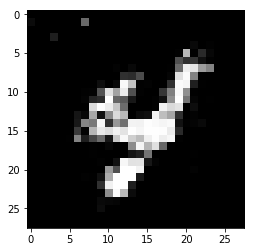

In [53]:
print(gen_labels.shape)
print(gen_images.shape)

print(gen_labels[5004])
plt.imshow(gen_images[5004,:,:, 0], cmap='gray')

print(classif.metrics_names)